Possible improvements:

- Use the crosscheck table to merge DR2 and DR3

- Check the mass: some stars do not have mass information? 


note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 408 to 218



In [1]:
from astroquery.gaia import Gaia
# Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"  # Select Data Release 2
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default

import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad

import pandas as pd



In [2]:
from openpyxl import load_workbook

def adjust_column_widths(excel_file):
    """
    Load an Excel workbook, adjust the column widths based on the maximum length of data in each column,
    and save the workbook.

    Parameters:
    - directory: str, the path to the directory containing the Excel file.
    - excel_file: str, the name of the Excel file to be processed.
    """
    # Load the workbook and select the active worksheet
    workbook = load_workbook(excel_file)
    worksheet = workbook.active

    # Adjust the column widths
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter  # Get the column letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        worksheet.column_dimensions[column_letter].width = adjusted_width

    # Save the workbook
    workbook.save(excel_file)




In [3]:
def calculate_habitable_zone(T_eff, L_ratio):
    """
    Calculate the habitable zone boundary based on Kopparapu et al. (2013) Equations 2 & 3,
    using only the "Runaway Greenhouse" limit (Conservative inner boundary).
    
    Parameters:
    T_eff (float): Effective temperature of the star in Kelvin
    
    Returns:
    float: Distance of the habitable zone boundary in AU
    """

    T_sun = 5780  # Effective temperature of the Sun in Kelvin

    # Coefficients for "Runaway Greenhouse" from Table 3 in the paper
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]

    '''
    "Recent Venus": 
    S_eff_sun, a, b, c, d = [1.7753, 1.4316E-4, 2.9875E-9, -7.5702E-12, -1.1635E-15]
    "Runaway Greenhouse": 
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]
    "Moist Greenhouse":
    S_eff_sun, a, b, c, d = [1.0140, 8.1774E-5, 1.7063E-9, -4.3241E-12, -6.6462E-16]
    "Maximum Greenhouse":
    S_eff_sun, a, b, c, d = [0.3438, 5.8942E-5, 1.6558E-9, -3.0045E-12, -5.2983E-16]
    "Early Mars":
    S_eff_sun, a, b, c, d = [0.3179, 5.4513E-5, 1.5313E-9, -2.7786E-12, -4.8997E-16]
    '''

    T_star = T_eff - 5780
    S_eff = S_eff_sun + a*T_star + b*T_star**2 + c*T_star**3 + d*T_star**4
    distance = np.sqrt(L_ratio / S_eff)
    
    return distance

### Testing 1. Qeury Gaia DR2/3 data

names: https://gaia.aip.de/metadata/gaiadr3/gaia_source/

In [267]:
import pandas as pd
from astroquery.gaia import Gaia

# Query for the supplementary table
query_supp = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, ap.teff_gspphot_marcs, ap.mass_flame_spec, ap.lum_flame_spec, ap.radius_flame_spec
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters_supp AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 12 
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 10
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
"""

# Execute the supplementary table query
job_supp = Gaia.launch_job_async(query_supp)
results_supp = job_supp.get_results().to_pandas()

# Query for the main table
query_main = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame, ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 12 
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 10
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
"""

# Execute the main table query
job_main = Gaia.launch_job_async(query_main)
results_main = job_main.get_results().to_pandas()

# Convert source_id columns to strings
results_main['source_id'] = results_main['source_id'].astype(str)
results_supp['source_id'] = results_supp['source_id'].astype(str)

# Select only unique columns from each dataset
results_supp_unique = results_supp[['source_id', 'teff_gspphot_marcs', 'mass_flame_spec', 'lum_flame_spec', 'radius_flame_spec']]
results_main_unique = results_main[['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'parallax', 'teff_gspphot', 'mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']]

# Merge the results, prioritizing the supplementary table
results_merged = pd.merge(
    results_main_unique,
    results_supp_unique,
    on='source_id',
    how='outer',
    suffixes=('', '_supp')
)

# Fill missing values from the main table with values from the supplementary table
results_merged['teff_gspphot'] = results_merged['teff_gspphot_marcs'].combine_first(results_merged['teff_gspphot'])
results_merged['mass'] = results_merged['mass_flame'].combine_first(results_merged['mass_flame_spec'])
results_merged['luminosity'] = results_merged['lum_flame'].combine_first(results_merged['lum_flame_spec'])
results_merged['radius'] = results_merged['radius_flame'].combine_first(results_merged['radius_flame_spec'])

# Drop the individual columns if needed
results_final = results_merged.drop(columns=['teff_gspphot', 'mass_flame', 'lum_flame', 'radius_flame', 'mass_flame_spec', 'lum_flame_spec', 'radius_flame_spec'])

# Display the final results
print(results_final)

# Save the results
directory = '../results/'
results_supp.to_excel(directory+'results_supp.xlsx', index=False)
results_main.to_excel(directory+'results_main.xlsx', index=False)
results_final.to_excel(directory+'results_final.xlsx', index=False)


adjust_column_widths(directory+'results_supp.xlsx')
adjust_column_widths(directory+'results_main.xlsx')
adjust_column_widths(directory+'results_final.xlsx')


                source_id          ra        dec  phot_g_mean_mag  \
0     5937183024214130304  250.185079 -51.477674         6.224640   
1     5912398348432135552  262.774129 -60.684284         3.596028   
2     5912921509809469952  264.635582 -58.544378        11.327970   
3     5912928381756917888  264.019142 -58.666138        11.191809   
4     5912380962403300096  263.521562 -59.777571         7.459463   
...                   ...         ...        ...              ...   
2169  6176768149719900416         NaN        NaN              NaN   
2170  6175834462486641920         NaN        NaN              NaN   
2171  6173420003671144704         NaN        NaN              NaN   
2172  6175893556940258944         NaN        NaN              NaN   
2173  6175893561236253056         NaN        NaN              NaN   

      phot_bp_mean_mag  phot_rp_mean_mag     bp_rp   parallax  \
0             6.379528          5.939466  0.440062  19.588654   
1             3.600711          3.627106 

The code below does exactly the same as the one above

DR3

In [35]:
# Query for the supplementary table
query_combined = """
SELECT gs.source_id AS dr3_source_id, 
       gs.ra, 
       gs.dec, 
       gs.phot_g_mean_mag, 
       gs.phot_bp_mean_mag, 
       gs.phot_rp_mean_mag, 
       gs.bp_rp, 
       gs.parallax,
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs.teff_gspphot) AS teff_gspphot,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame) AS luminosity,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame) AS radius,
       ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs
LEFT JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs.source_id = ap_supp.source_id
LEFT JOIN gaiadr3.astrophysical_parameters AS ap 
    ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
"""

# Execute the main table query
job_combined = Gaia.launch_job_async(query_combined)
dr3 = job_combined.get_results().to_pandas()
dr3['dr3_source_id'] = dr3['dr3_source_id'].astype(str)

# Rename the columns to match the desired headers
dr3 = dr3.rename(columns={
    'ra': 'RA',
    'dec': 'DEC',
    'phot_g_mean_mag': 'Phot G Mean Mag',
    'phot_bp_mean_mag': 'Phot BP Mean Mag',
    'phot_rp_mean_mag': 'Phot RP Mean Mag',
    'bp_rp': 'BP-RP',
    'parallax': 'Parallax',
    'teff_gspphot': 'T_eff [K]',
    'mass': 'Mass [M_Sun]',
    'luminosity': 'Luminosity [L_Sun]',
    'radius': 'Radius [R_Sun]',
    'spectraltype_esphs': 'Spectral Type'
})

# Save the updated dataframe to Excel
directory = '../results/'
filename = directory + 'results_dr3.xlsx'
dr3.to_excel(filename, index=False)
adjust_column_widths(filename)

# Display the first few rows of the dataframe
display(dr3.head())
len(dr3)

INFO: Query finished. [astroquery.utils.tap.core]


dr3_source_id          RA        DEC  Phot G Mean Mag  \
0  4683897617110115200    6.482505 -77.252795         2.680732   
1  5698015743046182272  121.885630 -24.304116         2.750589   
2  5826168461855385472  238.783806 -63.432511         2.784391   
3  6838311796136238976  326.761392 -16.128607         2.836813   
4  4269932382607207040  275.325059  -2.901943         2.990450   

   Phot BP Mean Mag  Phot RP Mean Mag     BP-RP    Parallax T_eff [K]  \
0          3.295626          2.371489  0.924137  133.719406             
1          3.302004          2.512174  0.789830   51.399886             
2          3.186963          2.558162  0.628800   80.485412             
3          3.290359          2.603107  0.687251   85.940560             
4          3.710574          2.473570  1.237004   52.441308             

  Mass [M_Sun] Luminosity [L_Sun] Radius [R_Sun] Spectral Type  
0                                                            F  
1                                                            F  
2                                                            A  
3                                                            B  
4                                                            G

457

DR2 
use JOIN, because it seems when source_id2... <NA>

In [34]:
# Query for the supplementary table
'''
dr2['source_id'] are identical to dr2['dr2_source_id']
'''

query_combined = """
SELECT gs.source_id AS dr2_source_id, crossmatch.dr3_source_id,
       gs.ra, 
       gs.dec, 
       gs.phot_g_mean_mag, 
       gs.phot_bp_mean_mag, 
       gs.phot_rp_mean_mag, 
       gs.bp_rp, 
       gs.parallax,
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs.teff_val) AS teff_gspphot,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame, gs.lum_val) AS luminosity,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame, gs.radius_val) AS radius,
       ap.spectraltype_esphs
FROM gaiadr2.gaia_source AS gs
LEFT JOIN gaiadr3.dr2_neighbourhood AS crossmatch
    ON gs.source_id = crossmatch.dr2_source_id
LEFT JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON crossmatch.dr3_source_id = ap_supp.source_id
LEFT JOIN gaiadr3.astrophysical_parameters AS ap 
    ON crossmatch.dr3_source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND COALESCE(ap_supp.radius_flame_spec, ap.radius_flame) < 3
  AND COALESCE(ap_supp.lum_flame_spec, ap.lum_flame) < 10
  AND COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot) < 7000  
"""

# Execute the main table query
job_combined = Gaia.launch_job_async(query_combined)
dr2 = job_combined.get_results().to_pandas()
dr2['dr2_source_id'] = dr2['dr2_source_id'].astype(str)
dr2['dr3_source_id'] = dr2['dr3_source_id'].astype(str)

# Rename the columns to match the desired headers
dr2 = dr2.rename(columns={
    'ra': 'RA',
    'dec': 'DEC',
    'phot_g_mean_mag': 'Phot G Mean Mag',
    'phot_bp_mean_mag': 'Phot BP Mean Mag',
    'phot_rp_mean_mag': 'Phot RP Mean Mag',
    'bp_rp': 'BP-RP',
    'parallax': 'Parallax',
    'teff_gspphot': 'T_eff [K]',
    'mass': 'Mass [M_Sun]',
    'luminosity': 'Luminosity [L_Sun]',
    'radius': 'Radius [R_Sun]',
    'spectraltype_esphs': 'Spectral Type'
})

# Save the updated dataframe to Excel
filename = directory + 'results_dr2.xlsx'
dr2.to_excel(filename, index=False)
adjust_column_widths(filename)

# Display the first few rows of the dataframe
display(dr2.head())
len(dr2)

INFO: Query finished. [astroquery.utils.tap.core]


dr2_source_id        dr3_source_id          RA        DEC  \
0  4911306239828325760  4911306239828325760   24.950579 -56.196402   
1  4911306239828325632  4911306239828325632   24.951252 -56.193253   
2  5640565607657897728  5640565607657897728  128.208941 -31.497569   
3  3657653114880309248  3657653114880309248  210.259726  -2.652290   
4  3359074685047632640  3359074685047632640   99.291543  17.566270   

   Phot G Mean Mag  Phot BP Mean Mag  Phot RP Mean Mag     BP-RP    Parallax  \
0         5.604027          6.110481          5.017446  1.093035  122.133341   
1         5.481575          5.975546          4.918038  1.057508  122.055156   
2         6.150999          6.585626          5.606073  0.979553   82.090036   
3         8.858808          9.961246          7.841961  2.119285   96.039794   
4         8.876039          9.875572          7.916457  1.959115   99.916379   

   T_eff [K] Mass [M_Sun] Luminosity [L_Sun] Radius [R_Sun] Spectral Type  
0   4902.265    0.8265656          0.3073524      0.7482267             G  
1    5044.24     0.848425          0.3307818     0.72947353             G  
2   5207.114   0.87969726         0.39650527      0.7812532             G  
3  3637.6152     0.527742         0.04382887      0.5488766             M  
4   3741.691                     0.040032268     0.53797454             M

288

dr2/dr3

In [45]:
# Query for the supplementary table
'''
dr2['source_id'] are identical to dr2['dr2_source_id']
'''

query_combined = """
SELECT gs2.source_id AS dr2_source_id, 
       gs3.source_id AS dr3_source_id, 
       crossmatch.dr3_source_id,
       COALESCE(gs3.ra, gs2.ra) AS ra,
       COALESCE(gs3.dec, gs2.dec) AS dec, 
       COALESCE(gs3.phot_g_mean_mag, gs2.phot_g_mean_mag) AS phot_g_mean_mag, 
       COALESCE(gs3.phot_bp_mean_mag, gs2.phot_bp_mean_mag) AS phot_bp_mean_mag, 
       COALESCE(gs3.phot_rp_mean_mag, gs2.phot_rp_mean_mag) AS phot_rp_mean_mag, 
       COALESCE(gs3.bp_rp, gs2.bp_rp) AS bp_rp, 
       COALESCE(gs3.parallax, gs2.parallax) AS parallax,
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs3.teff_gspphot, gs2.teff_val) AS teff_gspphot,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame, gs2.lum_val) AS luminosity,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame, gs2.radius_val) AS radius,
       ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs3 
FULL JOIN gaiadr3.dr2_neighbourhood AS crossmatch
    ON gs3.source_id = crossmatch.dr3_source_id
FULL JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs3.source_id = ap_supp.source_id
FULL JOIN gaiadr3.astrophysical_parameters AS ap 
    ON gs3.source_id = ap.source_id
FULL JOIN gaiadr2.gaia_source AS gs2
    ON crossmatch.dr2_source_id = gs2.source_id
WHERE COALESCE(gs3.phot_g_mean_mag, gs2.phot_g_mean_mag) < 9
  AND COALESCE(gs3.dec, gs2.dec) BETWEEN -90 AND 60
  AND COALESCE(gs3.parallax, gs2.parallax) >= 50
  AND (gs2.duplicated_source = 'false' OR gs2.duplicated_source IS NULL)
  AND (gs3.duplicated_source = 'false' OR gs3.duplicated_source IS NULL)
"""

# Execute the main table query
job_combined = Gaia.launch_job_async(query_combined)
dr2_dr3 = job_combined.get_results().to_pandas()
dr2_dr3['dr2_source_id'] = dr2_dr3['dr2_source_id'].astype(str)
dr2_dr3['dr3_source_id'] = dr2_dr3['dr3_source_id'].astype(str)

# Rename the columns to match the desired headers
dr2_dr3 = dr2_dr3.rename(columns={
    'ra': 'RA',
    'dec': 'DEC',
    'phot_g_mean_mag': 'Phot G Mean Mag',
    'phot_bp_mean_mag': 'Phot BP Mean Mag',
    'phot_rp_mean_mag': 'Phot RP Mean Mag',
    'bp_rp': 'BP-RP',
    'parallax': 'Parallax',
    'teff_gspphot': 'T_eff [K]',
    'mass': 'Mass [M_Sun]',
    'luminosity': 'Luminosity [L_Sun]',
    'radius': 'Radius [R_Sun]',
    'spectraltype_esphs': 'Spectral Type'
})

# Save the updated dataframe to Excel
filename = directory + 'results_dr2_dr3.xlsx'
dr2_dr3.to_excel(filename, index=False)
adjust_column_widths(filename)

# Display the first few rows of the dataframe
display(dr2_dr3.head())
len(dr2_dr3)

500 Error 500:
null


HTTPError: Error 500:
null

In [ ]:
SELECT gs2.source_id AS dr2_source_id, 
       gs3.source_id AS dr3_source_id, 
       crossmatch.dr3_source_id,
       COALESCE(gs3.ra, gs2.ra) AS ra,
       COALESCE(gs3.dec, gs2.dec) AS dec, 
       COALESCE(gs3.phot_g_mean_mag, gs2.phot_g_mean_mag) AS phot_g_mean_mag, 
       COALESCE(gs3.phot_bp_mean_mag, gs2.phot_bp_mean_mag) AS phot_bp_mean_mag, 
       COALESCE(gs3.phot_rp_mean_mag, gs2.phot_rp_mean_mag) AS phot_rp_mean_mag, 
       COALESCE(gs3.bp_rp, gs2.bp_rp) AS bp_rp, 
       COALESCE(gs3.parallax, gs2.parallax) AS parallax,
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs3.teff_gspphot, gs2.teff_val) AS teff_gspphot,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame, gs2.lum_val) AS luminosity,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame, gs2.radius_val) AS radius,
       ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs3 
FULL JOIN gaiadr3.dr2_neighbourhood AS crossmatch
    ON gs3.source_id = crossmatch.dr3_source_id
FULL JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs3.source_id = ap_supp.source_id
FULL JOIN gaiadr3.astrophysical_parameters AS ap 
    ON gs3.source_id = ap.source_id
FULL JOIN gaiadr2.gaia_source AS gs2
    ON crossmatch.dr2_source_id = gs2.source_id
WHERE COALESCE(gs3.phot_g_mean_mag, gs2.phot_g_mean_mag) < 9
  AND COALESCE(gs3.dec, gs2.dec) BETWEEN -90 AND 60
  AND COALESCE(gs3.parallax, gs2.parallax) >= 50
  AND (gs2.duplicated_source = 'false' OR gs2.duplicated_source IS NULL)
  AND (gs3.duplicated_source = 'false' OR gs3.duplicated_source IS NULL)


In [23]:
dr2_source_ids = tuple(dr2['dr2_source_id'])

crossmatch_query = f"""
SELECT dr2_source_id, dr3_source_id
FROM gaiadr3.dr2_neighbourhood
WHERE dr2_source_id IN {dr2_source_ids}
"""

# Execute the crossmatch query
job_crossmatch = Gaia.launch_job_async(crossmatch_query)
crossmatch_results = job_crossmatch.get_results().to_pandas()
crossmatch_results['dr2_source_id'] = crossmatch_results['dr2_source_id'].astype(str)
crossmatch_results['dr3_source_id'] = crossmatch_results['dr3_source_id'].astype(str)
filename = directory + 'crossmatch_results.xlsx'
crossmatch_results.to_excel(filename, index=False)
adjust_column_widths(filename)
crossmatch_results


INFO: Query finished. [astroquery.utils.tap.core]


dr2_source_id        dr3_source_id
0      25488745411919360    25488745411919360
1      53112944270520832    53112944270520832
2      70051608089857536    70051608089857536
3      96331172942614528    96331172942614528
4     145421309108301184   145421309108301184
..                   ...                  ...
293  6832674634380238848  6832674634380238848
294  6847167606385195648  6847167606385195648
295  6863535898551993472  6863535898551993472
296  6866310172545095424  6866310172545095424
297  6885342959337741184  6885342959337741184

[298 rows x 2 columns]

In [185]:
import pandas as pd

# Merge dr2 and dr3 on 'dr3_source_id'
merged_df = pd.merge(dr3, dr2, on='dr3_source_id', suffixes=('_dr3', '_dr2'), how='outer')

# Create a new DataFrame with preferred values from dr3, falling back to dr2 if necessary
final_df = pd.DataFrame()

# Include 'dr2_source_id' and 'dr3_source_id' as the first two columns
final_df['dr2_source_id'] = merged_df['dr2_source_id']
final_df['dr3_source_id'] = merged_df['dr3_source_id']

# List of columns to merge, assuming dr3 and dr2 have the same set of columns
columns_to_merge = [
    'RA', 'DEC', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP',
    'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]',
    'Radius [R_Sun]', 'Spectral Type'
]

# Iterate over the columns to merge
for column in columns_to_merge:
    final_df[column] = merged_df[f'{column}_dr3'].combine_first(merged_df[f'{column}_dr2'])

# Save the final DataFrame to Excel
filename = directory + 'results_dr2_dr3.xlsx'
final_df.to_excel(filename, index=False)
adjust_column_widths(filename)

# Display the first few rows of the final DataFrame
display(final_df.head())
print(f"Number of entries in the final DataFrame: {len(final_df)}")


dr2_source_id        dr3_source_id          RA        DEC  Phot G Mean Mag  \
0           NaN  5912380962403300096  263.521562 -59.777571         7.459463   
1           NaN  1837182671876057472  304.555931  29.203753         8.813396   
2           NaN  1837182676181120896  304.556314  29.203715         9.528364   
3           NaN  4471238083887731456  270.637685   4.417389         8.704765   
4           NaN  4471087175915086080  271.405998   4.655748         6.649316   

   Phot BP Mean Mag  Phot RP Mean Mag     BP-RP   Parallax  T_eff [K]  \
0          7.753087          6.992328  0.760759  26.695519   5826.763   
1          9.034739          7.764806  1.269933  29.773776  4862.6016   
2          9.299628          7.864410  1.435218  29.769599   5044.509   
3          9.150189          8.093346  1.056844  25.687915   5015.104   
4          6.953541          6.166453  0.787088  41.474060   5691.311   

  Mass [M_Sun] Luminosity [L_Sun] Radius [R_Sun] Spectral Type  
0    1.0270743          1.0723715      1.0139297             G  
1    0.7625022         0.30370355     0.88247246             G  
2   0.70530427         0.18704037      0.8509922             G  
3    0.7943323         0.39840892     0.83611274             K  
4    1.0329351          0.9404929     0.87734646             G

Number of entries in the final DataFrame: 6099


In [186]:
merged_df

dr3_source_id      RA_dr3    DEC_dr3  Phot G Mean Mag_dr3  \
0     5912380962403300096  263.521562 -59.777571             7.459463   
1     1837182671876057472  304.555931  29.203753             8.813396   
2     1837182676181120896  304.556314  29.203715             9.528364   
3     4471238083887731456  270.637685   4.417389             8.704765   
4     4471087175915086080  271.405998   4.655748             6.649316   
...                   ...         ...        ...                  ...   
6094  5407414407508423680         NaN        NaN                  NaN   
6095  5407414407508442112         NaN        NaN                  NaN   
6096  5114240352186781696         NaN        NaN                  NaN   
6097  4464207428577214464         NaN        NaN                  NaN   
6098  3239548665775612928         NaN        NaN                  NaN   

      Phot BP Mean Mag_dr3  Phot RP Mean Mag_dr3  BP-RP_dr3  Parallax_dr3  \
0                 7.753087              6.992328   0.760759     26.695519   
1                 9.034739              7.764806   1.269933     29.773776   
2                 9.299628              7.864410   1.435218     29.769599   
3                 9.150189              8.093346   1.056844     25.687915   
4                 6.953541              6.166453   0.787088     41.474060   
...                    ...                   ...        ...           ...   
6094                   NaN                   NaN        NaN           NaN   
6095                   NaN                   NaN        NaN           NaN   
6096                   NaN                   NaN        NaN           NaN   
6097                   NaN                   NaN        NaN           NaN   
6098                   NaN                   NaN        NaN           NaN   

     T_eff [K]_dr3 Mass [M_Sun]_dr3  ... Phot G Mean Mag_dr2  \
0         5826.763        1.0270743  ...                 NaN   
1        4862.6016        0.7625022  ...                 NaN   
2         5044.509       0.70530427  ...                 NaN   
3         5015.104        0.7943323  ...                 NaN   
4         5691.311        1.0329351  ...                 NaN   
...            ...              ...  ...                 ...   
6094           NaN              NaN  ...            8.085078   
6095           NaN              NaN  ...           10.250566   
6096           NaN              NaN  ...           10.269168   
6097           NaN              NaN  ...            7.247616   
6098           NaN              NaN  ...            6.872698   

     Phot BP Mean Mag_dr2 Phot RP Mean Mag_dr2 BP-RP_dr2  Parallax_dr2  \
0                     NaN                  NaN       NaN           NaN   
1                     NaN                  NaN       NaN           NaN   
2                     NaN                  NaN       NaN           NaN   
3                     NaN                  NaN       NaN           NaN   
4                     NaN                  NaN       NaN           NaN   
...                   ...                  ...       ...           ...   
6094             8.485525             7.568351  0.917174     26.992809   
6095            11.039318             9.417773  1.621545     26.910121   
6096            11.106816             9.401341  1.705475     35.218015   
6097             7.659267             6.716437  0.942830     41.259192   
6098             7.178187             6.451646  0.726541     27.744111   

      T_eff [K]_dr2  Mass [M_Sun]_dr2  Luminosity [L_Sun]_dr2  \
0               NaN               NaN                     NaN   
1               NaN               NaN                     NaN   
2               NaN               NaN                     NaN   
3               NaN               NaN                     NaN   
4               NaN               NaN                     NaN   
...             ...               ...                     ...   
6094      5409.9487         0.8972189              0.59520715   
6095       4153.005         0.66

In [188]:

merged_results = merged_df.copy()

#-------------------------------------------------------------
# Data Cleaning
#-------------------------------------------------------------

# ***** Step 1: Identify repeated dr2_source_id entries *****
non_empty_dr2 = merged_results[merged_results['dr2_source_id'].notna() & (merged_results['dr2_source_id'] != '')]
repeated_dr2_ids = non_empty_dr2[non_empty_dr2.duplicated('dr2_source_id', keep=False)]['dr2_source_id'].unique()
repeated_entries = merged_results[merged_results['dr2_source_id'].isin(repeated_dr2_ids)]

# Save repeated entries to Excel
repeated_entries.to_excel(directory + 'repeated_entries.xlsx', index=False)
adjust_column_widths(directory + 'repeated_entries.xlsx')

# ***** Step 2: Clean repeated entries *****
def check_dr3_availability(row):
    '''
    Function to check if any DR3 data is available for a given row.
    '''
    dr3_columns = [col for col in row.index if col.endswith('_dr3')]
    return not row[dr3_columns].isnull().all()

def process_repeated_group(group):
    '''
    Function to process a group of repeated entries with the same dr2_source_id.
    '''
    if len(group) != 2:
        # If there are more than 2 entries, keep only the first one
        return group.iloc[1:].index.tolist()  # Return indices of rows to remove
    
    row1, row2 = group.iloc[0], group.iloc[1]
    dr3_available1 = check_dr3_availability(row1)
    dr3_available2 = check_dr3_availability(row2)
    
    if not dr3_available1 and not dr3_available2:
        # If both rows have no DR3 data, remove the second one
        return [group.index[1]]
    elif dr3_available1 and not dr3_available2:
        # If only the first row has DR3 data, remove the second one
        return [group.index[1]]
    elif not dr3_available1 and dr3_available2:
        # If only the second row has DR3 data, remove the first one
        return [group.index[0]]
    else:
        # If both rows have DR3 data, remove the second one
        return [group.index[1]]

# Process repeated entries and get indices of rows to remove
rows_to_remove_indices = repeated_entries.groupby('dr2_source_id').apply(process_repeated_group).sum()

# Get the rows to be removed
rows_to_remove = repeated_entries.loc[rows_to_remove_indices]

# Remove the identified rows from merged_results
clean_merged_results = merged_results[~merged_results.index.isin(rows_to_remove.index)]

# Reset index of clean_merged_results
clean_merged_results = clean_merged_results.reset_index(drop=True)

# Print some information about the results
print(f"Original shape of merged_results: {merged_results.shape}")
print(f"Shape after removing duplicates: {clean_merged_results.shape}")
print(f"Number of rows removed: {merged_results.shape[0] - clean_merged_results.shape[0]}")

# Save clean_merged_results to Excel
clean_merged_results.to_excel(directory + 'clean_merged_results.xlsx', index=False)
adjust_column_widths(directory + 'clean_merged_results.xlsx')

# Save rows_to_remove to Excel
rows_to_remove.to_excel(directory + 'removed_rows.xlsx', index=False)
adjust_column_widths(directory + 'removed_rows.xlsx')

# Check if there are still any duplicates
remaining_duplicates = clean_merged_results[clean_merged_results.duplicated('dr2_source_id', keep=False)]
print(f"\nNumber of remaining duplicate dr2_source_id: {len(remaining_duplicates['dr2_source_id'].unique())}")

if not remaining_duplicates.empty:
    print("\nExample of remaining duplicates:")
    print(remaining_duplicates.groupby('dr2_source_id').first().head())
else:
    print("\nNo remaining duplicates found.")

# ***** Step 3: Consolidate the data *****
# Create a new DataFrame to store the final consolidated data
df = clean_merged_results.copy()

# Function to choose between DR3 and DR2 values
def choose_value(row, col_name):
    dr3_col = f'{col_name}_dr3'
    dr2_col = f'{col_name}_dr2'
    return row[dr3_col] if pd.notnull(row[dr3_col]) else row[dr2_col]

# List of columns to process
columns_to_process = ['RA', 'DEC', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP',
    'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]',
    'Radius [R_Sun]', 'Spectral Type']

# Process each column
for col in columns_to_process:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# # For other columns
# other_columns = ['mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']
# for col in other_columns:
#     df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# # Add bp_rp column from DR3 if available
# df['bp_rp'] = df['bp_rp'].fillna(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'])

# # Add the new source_id column
# df['source_id'] = df['source_id_dr3'].fillna(df['source_id_dr2'])

# Update the final columns list to include the new source_id column
final_columns = ['dr2_source_id', 'dr3_source_id', 'RA', 'DEC', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP',
    'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]',
    'Radius [R_Sun]', 'Spectral Type']

# Create the final dataframe
df_consolidated = df[final_columns]

# -------------------------------------------------------------
# Add SIMBAD information (HD, GJ, HIP numbers and object type)
# -------------------------------------------------------------
# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Function to get additional information from SIMBAD
def get_simbad_info(source_id):
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]
    
    return {
        'HD Number': ', '.join(hd_numbers) if hd_numbers else None,
        'GJ Number': ', '.join(gj_numbers) if gj_numbers else None,
        'HIP Number': ', '.join(hip_numbers) if hip_numbers else None,
        'Object Type': object_type
    }

# Create a new DataFrame instead of modifying the existing one
new_columns = ['source_id', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']
df_new = pd.DataFrame(columns=new_columns)

# Populate the new DataFrame
df_new['source_id'] = df_consolidated['dr3_source_id'].fillna(df_consolidated['dr2_source_id'])



import time
from astroquery.simbad import Simbad

def get_simbad_info_with_retry(source_id, retries=3, delay=5):
    for attempt in range(retries):
        try:
            result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
            if result_table is not None:
                ids = result_table['IDS'][0].split('|')
                hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
                gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
                hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
                object_type = result_table['OTYPE'][0]
                return {
                    'HD Number': ', '.join(hd_numbers) if hd_numbers else None,
                    'GJ Number': ', '.join(gj_numbers) if gj_numbers else None,
                    'HIP Number': ', '.join(hip_numbers) if hip_numbers else None,
                    'Object Type': object_type
                }
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(delay)
    return None

# Use the retry function
for index, row in df_new.iterrows():
    simbad_info = get_simbad_info_with_retry(row['source_id'])
    if simbad_info:
        df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
        df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
        df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
        df_new.loc[index, 'Object Type'] = simbad_info['Object Type']









# # Fetch SIMBAD information for each star
# for index, row in df_new.iterrows():
#     simbad_info = get_simbad_info(row['source_id'])
#     df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
#     df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
#     df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
#     df_new.loc[index, 'Object Type'] = simbad_info['Object Type']

# Combine the new DataFrame with the original one
df_consolidated = pd.concat([df_consolidated, df_new[['HD Number', 'GJ Number', 'HIP Number', 'Object Type']]], axis=1)

# Update the final columns list to include the new columns
final_columns.extend(['HD Number', 'GJ Number', 'HIP Number', 'Object Type'])

# Create the final dataframe with the updated column list
df_consolidated = df_consolidated[final_columns]

# Rename the columns
# df_consolidated = df_consolidated.rename(columns={
#     'mass_flame': 'Mass [M_Sun]',
#     'lum_flame': 'Luminosity [L_Sun]',
#     'radius_flame': 'Radius [R_Sun]',
#     'phot_g_mean_mag': 'Phot G Mean Mag',
#     'phot_bp_mean_mag': 'Phot BP Mean Mag',
#     'phot_rp_mean_mag': 'Phot RP Mean Mag',
#     'bp_rp': 'BP-RP',
#     'parallax': 'Parallax',
#     'ra': 'RA',
#     'dec': 'DEC',
#     'spectraltype_esphs': 'Spectral Type'
# })

# Save the result to a new Excel file
df_consolidated.to_excel(directory + 'consolidated_results.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results.xlsx')

# Display some statistics
print(f"Total number of stars: {len(df_consolidated)}")
print(f"Number of stars with DR3 source_id: {df_consolidated['dr3_source_id'].notna().sum()}")
print(f"Number of stars with only DR2 source_id: {df_consolidated['dr3_source_id'].isna().sum()}")
print(f"Number of stars with HD Number: {df_consolidated['HD Number'].notna().sum()}")
print(f"Number of stars with GJ Number: {df_consolidated['GJ Number'].notna().sum()}")
print(f"Number of stars with HIP Number: {df_consolidated['HIP Number'].notna().sum()}")


#-------------------------------------------------------------
# Extract data with mass and luminosity information available
#-------------------------------------------------------------
# Filter out stars with missing mass or luminosity information
# df_filtered = df_consolidated[(df_consolidated['Mass [M_Sun]'].notna()) & (df_consolidated['Luminosity [L_Sun]'].notna())]
df_consolidated['Mass [M_Sun]'].replace('', np.nan, inplace=True)
df_consolidated['Luminosity [L_Sun]'].replace('', np.nan, inplace=True)
df_consolidated['Radius [R_Sun]'].replace('', np.nan, inplace=True)
df_consolidated['T_eff [K]'].replace('', np.nan, inplace=True)
df_filtered = df_consolidated.dropna(subset=['Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'T_eff [K]'])


# Remove the entry where the effective temperature is larger than 7000K 
# df_filtered = df_filtered[df_filtered['T_eff [K]'] < 7000]

# Save the filtered consolidated data to a new Excel file
df_filtered.to_excel(directory + 'consolidated_results_filtered.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results_filtered.xlsx')
display(df_filtered)

Original shape of merged_results: (6099, 26)
Shape after removing duplicates: (5925, 26)
Number of rows removed: 174

Number of remaining duplicate dr2_source_id: 1

Example of remaining duplicates:
Empty DataFrame
Columns: [dr3_source_id, RA_dr3, DEC_dr3, Phot G Mean Mag_dr3, Phot BP Mean Mag_dr3, Phot RP Mean Mag_dr3, BP-RP_dr3, Parallax_dr3, T_eff [K]_dr3, Mass [M_Sun]_dr3, Luminosity [L_Sun]_dr3, Radius [R_Sun]_dr3, Spectral Type_dr3, RA_dr2, DEC_dr2, Phot G Mean Mag_dr2, Phot BP Mean Mag_dr2, Phot RP Mean Mag_dr2, BP-RP_dr2, Parallax_dr2, T_eff [K]_dr2, Mass [M_Sun]_dr2, Luminosity [L_Sun]_dr2, Radius [R_Sun]_dr2, Spectral Type_dr2]
Index: []

[0 rows x 25 columns]


Total number of stars: 5925
Number of stars with DR3 source_id: 5925
Number of stars with only DR2 source_id: 0
Number of stars with HD Number: 2437
Number of stars with GJ Number: 1361
Number of stars with HIP Number: 2752


dr2_source_id        dr3_source_id          RA        DEC  \
0                     NaN  5912380962403300096  263.521562 -59.777571   
1                     NaN  1837182671876057472  304.555931  29.203753   
2                     NaN  1837182676181120896  304.556314  29.203715   
3                     NaN  4471238083887731456  270.637685   4.417389   
4                     NaN  4471087175915086080  271.405998   4.655748   
...                   ...                  ...         ...        ...   
5920  5407414407508423424  5407414407508423680  153.231514 -47.474697   
5921  5407414407508441856  5407414407508442112  153.233454 -47.475572   
5922  5114240352186781952  5114240352186781696   55.774785 -12.894209   
5923  4464207428577214464  4464207428577214464  243.327612  13.526227   
5924  3239548665775613056  3239548665775612928   73.983450   4.669605   

      Phot G Mean Mag  Phot BP Mean Mag  Phot RP Mean Mag     BP-RP  \
0            7.459463          7.753087          6.992328  0.760759   
1            8.813396          9.034739          7.764806  1.269933   
2            9.528364          9.299628          7.864410  1.435218   
3            8.704765          9.150189          8.093346  1.056844   
4            6.649316          6.953541          6.166453  0.787088   
...               ...               ...               ...       ...   
5920         8.085078          8.485525          7.568351  0.917174   
5921        10.250566         11.039318          9.417773  1.621545   
5922        10.269168         11.106816          9.401341  1.705475   
5923         7.247616          7.659267          6.716437  0.942830   
5924         6.872698          7.178187          6.451646  0.726541   

       Parallax  T_eff [K] Mass [M_Sun] Luminosity [L_Sun] Radius [R_Sun]  \
0     26.695519   5826.763    1.0270743          1.0723715      1.0139297   
1     29.773776  4862.6016    0.7625022         0.30370355     0.88247246   
2     29.769599   5044.509   0.70530427         0.18704037      0.8509922   
3     25.687915   5015.104    0.7943323         0.39840892     0.83611274   
4     41.474060   5691.311    1.0329351          0.9404929     0.87734646   
...         ...        ...          ...                ...            ...   
5920  26.992809  5409.9487    0.8972189         0.59520715      0.8781961   
5921  26.910121   4153.005    0.6670827         0.12740755      0.6894917   
5922  35.218015  4021.2742    0.6024087        0.081752606      0.6964844   
5923  41.259192  5289.4365    0.9276119         0.54569334      0.8102098   
5924  27.744111   5981.258    1.1333854          1.6295242      1.1313105   

     Spectral Type   HD Number              GJ Number HIP Number Object Type  
0                G   HD 158630                   None  HIP 85960     HighPM*  
1                G  HD 334100A                   None       None     HighPM*  
2                G  HD 334100B                   None       None     HighPM*  
3                K   HD 164759                   None  HIP 88353     HighPM*  
4                G   HD 165401      GJ 9614, GJ 702.2  HIP 88622     HighPM*  
...            ...         ...                    ...        ...         ...  
5920             G         NaN                    NaN        NaN         NaN  
5921             K         NaN                    NaN        NaN         NaN  
5922             K         NaN                    NaN        NaN         NaN  
5923             G  HD 145958B  GJ 9548 B, GJ 615.1 B       None         SB*  
5924             F         NaN                    NaN        NaN         NaN  

[3284 rows x 18 columns]

## Older wroking version 

test the size of query

In [4]:
if 0:
  query_combined = """
  SELECT gs.source_id AS dr2_source_id,
        gs.ra, 
        gs.dec, 
        gs.phot_g_mean_mag, 
        gs.phot_bp_mean_mag, 
        gs.phot_rp_mean_mag, 
        gs.bp_rp, 
        gs.parallax,
        gs.duplicated_source
  FROM gaiadr2.gaia_source AS gs
  WHERE gs.phot_g_mean_mag BETWEEN 11 AND 12
    AND gs.dec BETWEEN -90 AND 60
  """

  # Execute the main table query
  job_combined = Gaia.launch_job_async(query_combined)
  dr2 = job_combined.get_results().to_pandas()
  dr2['dr2_source_id'] = dr2['dr2_source_id'].astype(str)

  # Save the updated dataframe to Excela
  filename = directory + 'test_dr2.xlsx'
  dr2.to_excel(filename, index=False)
  adjust_column_widths(filename)

  # Display the first few rows of the dataframea
  display(dr2.head())
  len(dr2)

In [5]:
# Define the column specifications based on the byte positions
colspecs = [
    (39, 45),  # Num    
    (10, 15),  # Teff
    (16, 28),  # Lum
]
# Define the column names
column_names = [
    "HIP Number",
    "T_eff [K]",
    "Luminosity [L_Sun]"
]

# Read the data into a DataFrame
df_CELESTA = pd.read_fwf("../data/Catalogue_CELESTA.txt", colspecs=colspecs, names=column_names, skiprows=28)

# Display the first few rows of the DataFrame
df_CELESTA.head()

HIP Number  T_eff [K]  Luminosity [L_Sun]
0           1       6388            8.728700
1           2       4506            0.613774
2           3       8968          374.866000
3           4       7005            8.451670
4           5       5064           27.361000

In [6]:
import logging
# Set the logging level for astroquery to ERROR to suppress warnings
logging.getLogger('astroquery').setLevel(logging.ERROR)

#-------------------------------------------------------------
# Define your DR2 query
#-------------------------------------------------------------
# including ap.mass_flame, ap.lum_flame, ap.radius_flame is necessary to get the astrophysical parameters 
# even though we force to use gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
# Without gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id, we would end up with the same clean merged results but without the astrophysical parameters
query_dr2 = """
SELECT gs.source_id, 
       gs.ra, 
       gs.dec, 
       gs.phot_g_mean_mag, 
       gs.phot_bp_mean_mag, 
       gs.phot_rp_mean_mag,
       gs.parallax,
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs.teff_val) AS teff_val,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass_flame,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame, gs.lum_val) AS lum_flame,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame, gs.radius_val) AS radius_flame,
       ap.spectraltype_esphs
FROM gaiadr2.gaia_source AS gs
LEFT JOIN gaiadr3.astrophysical_parameters AS ap 
    ON gs.source_id = ap.source_id
LEFT JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs.source_id = ap_supp.source_id
WHERE gs.phot_g_mean_mag < 10
  AND gs.dec BETWEEN -90 AND 25
  AND gs.parallax >= 50
"""

# WHERE gs.phot_g_mean_mag < 12
#   AND gs.dec BETWEEN -90 AND 25
#   AND gs.parallax >= 20

# Execute the DR2 query
job_dr2 = Gaia.launch_job_async(query_dr2)
results_dr2 = job_dr2.get_results()

# Extract DR2 source IDs
dr2_source_ids = tuple(results_dr2['source_id'])

#-------------------------------------------------------------
# Define the crossmatch query using the dr2_neighbourhood table
#-------------------------------------------------------------
crossmatch_query = f"""
SELECT dr2_source_id, dr3_source_id
FROM gaiadr3.dr2_neighbourhood
WHERE dr2_source_id IN {dr2_source_ids}
"""

# Execute the crossmatch query
job_crossmatch = Gaia.launch_job_async(crossmatch_query)
crossmatch_results = job_crossmatch.get_results()

#-------------------------------------------------------------
# Define your DR3 query
#-------------------------------------------------------------
query_dr3 = """
SELECT gs.source_id, 
       gs.ra, 
       gs.dec, 
       gs.phot_g_mean_mag, 
       gs.phot_bp_mean_mag, 
       gs.phot_rp_mean_mag,
       gs.bp_rp, 
       gs.parallax, 
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs.teff_gspphot) AS teff_gspphot,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass_flame,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame) AS lum_flame,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame) AS radius_flame,
       ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs
LEFT JOIN gaiadr3.astrophysical_parameters AS ap 
    ON gs.source_id = ap.source_id
LEFT JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs.source_id = ap_supp.source_id
WHERE gs.phot_g_mean_mag < 10
  AND gs.dec BETWEEN -90 AND 25
  AND gs.parallax >= 50
"""

# WHERE gs.phot_g_mean_mag < 12
#   AND gs.dec BETWEEN -90 AND 25
#   AND gs.parallax >= 20

# Execute the DR3 query
job_dr3 = Gaia.launch_job_async(query_dr3)
results_dr3 = job_dr3.get_results()

# Convert results to pandas DataFrames for easier merging
df_dr2= results_dr2.to_pandas()
df_crossmatch = crossmatch_results.to_pandas()
df_dr3 = results_dr3.to_pandas()

# Convert source_id columns to strings
df_dr2['source_id'] = df_dr2['source_id'].astype(str)
df_crossmatch['dr2_source_id'] = df_crossmatch['dr2_source_id'].astype(str)
df_crossmatch['dr3_source_id'] = df_crossmatch['dr3_source_id'].astype(str)
df_dr3['source_id'] = df_dr3['source_id'].astype(str)

#-------------------------------------------------------------
# Merge DR2 and crossmatch results
#-------------------------------------------------------------
merged_dr2_crossmatch = pd.merge(df_dr2, df_crossmatch, left_on='source_id', right_on='dr2_source_id', how='left')

# Merge the above result with DR3 results
merged_results = pd.merge(merged_dr2_crossmatch, df_dr3, left_on='dr3_source_id', right_on='source_id', suffixes=('_dr2', '_dr3'), how='outer')

# Save the results
directory = '../results/'
df_dr2.to_excel(directory+'dr2_results.xlsx', index=False)
df_dr3.to_excel(directory+'dr3_results.xlsx', index=False)
merged_results.to_excel(directory+'merged_results.xlsx', index=False)
adjust_column_widths(directory+'dr2_results.xlsx')
adjust_column_widths(directory+'dr3_results.xlsx')
adjust_column_widths(directory+'merged_results.xlsx')


#-------------------------------------------------------------
# Data Cleaning
#-------------------------------------------------------------

# ***** Step 1: Identify repeated dr2_source_id entries *****
non_empty_dr2 = merged_results[merged_results['dr2_source_id'].notna() & (merged_results['dr2_source_id'] != '')]
repeated_dr2_ids = non_empty_dr2[non_empty_dr2.duplicated('dr2_source_id', keep=False)]['dr2_source_id'].unique()
repeated_entries = merged_results[merged_results['dr2_source_id'].isin(repeated_dr2_ids)]

# Save repeated entries to Excel
repeated_entries.to_excel(directory + 'repeated_entries.xlsx', index=False)
adjust_column_widths(directory + 'repeated_entries.xlsx')

# ***** Step 2: Clean repeated entries *****
def check_dr3_availability(row):
    '''
    Function to check if any DR3 data is available for a given row.
    '''
    dr3_columns = [col for col in row.index if col.endswith('_dr3')]
    return not row[dr3_columns].isnull().all()

def process_repeated_group(group):
    '''
    Function to process a group of repeated entries with the same dr2_source_id.
    '''
    if len(group) != 2:
        # If there are more than 2 entries, keep only the first one
        return group.iloc[1:].index.tolist()  # Return indices of rows to remove
    
    row1, row2 = group.iloc[0], group.iloc[1]
    dr3_available1 = check_dr3_availability(row1)
    dr3_available2 = check_dr3_availability(row2)
    
    if not dr3_available1 and not dr3_available2:
        # If both rows have no DR3 data, remove the second one
        return [group.index[1]]
    elif dr3_available1 and not dr3_available2:
        # If only the first row has DR3 data, remove the second one
        return [group.index[1]]
    elif not dr3_available1 and dr3_available2:
        # If only the second row has DR3 data, remove the first one
        return [group.index[0]]
    else:
        # If both rows have DR3 data, remove the second one
        return [group.index[1]]

# Process repeated entries and get indices of rows to remove
rows_to_remove_indices = repeated_entries.groupby('dr2_source_id').apply(process_repeated_group).sum()

# Get the rows to be removed
rows_to_remove = repeated_entries.loc[rows_to_remove_indices]

# Remove the identified rows from merged_results
clean_merged_results = merged_results[~merged_results.index.isin(rows_to_remove.index)]

# Reset index of clean_merged_results
clean_merged_results = clean_merged_results.reset_index(drop=True)

# Print some information about the results
print(f"Original shape of merged_results: {merged_results.shape}")
print(f"Shape after removing duplicates: {clean_merged_results.shape}")
print(f"Number of rows removed: {merged_results.shape[0] - clean_merged_results.shape[0]}")

# Save clean_merged_results to Excel
clean_merged_results.to_excel(directory + 'clean_merged_results.xlsx', index=False)
adjust_column_widths(directory + 'clean_merged_results.xlsx')

# Save rows_to_remove to Excel
rows_to_remove.to_excel(directory + 'removed_rows.xlsx', index=False)
adjust_column_widths(directory + 'removed_rows.xlsx')

# Check if there are still any duplicates
remaining_duplicates = clean_merged_results[clean_merged_results.duplicated('dr2_source_id', keep=False)]
print(f"\nNumber of remaining duplicate dr2_source_id: {len(remaining_duplicates['dr2_source_id'].unique())}")

if not remaining_duplicates.empty:
    print("\nExample of remaining duplicates:")
    print(remaining_duplicates.groupby('dr2_source_id').first().head())
else:
    print("\nNo remaining duplicates found.")

# ***** Step 3: Consolidate the data *****
# Create a new DataFrame to store the final consolidated data
df = clean_merged_results.copy()

# Function to choose between DR3 and DR2 values
def choose_value(row, col_name):
    dr3_col = f'{col_name}_dr3'
    dr2_col = f'{col_name}_dr2'
    return row[dr3_col] if pd.notnull(row[dr3_col]) else row[dr2_col]

# List of columns to process
columns_to_process = ['ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'spectraltype_esphs']

# Process each column
for col in columns_to_process:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# Special handling for temperature
df['T_eff [K]'] = df.apply(lambda row: row['teff_gspphot'] if pd.notnull(row['teff_gspphot']) else row['teff_val'], axis=1)

# For other columns
other_columns = ['mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']
for col in other_columns:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# Add bp_rp column from DR3 if available
df['bp_rp'] = df['bp_rp'].fillna(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'])

# Add the new source_id column
df['source_id'] = df['source_id_dr3'].fillna(df['source_id_dr2'])

# Update the final columns list to include the new source_id column
final_columns = ['source_id', 'source_id_dr2', 'source_id_dr3', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 
                'bp_rp', 'parallax', 'T_eff [K]', 'mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']

# Create the final dataframe
df_consolidated = df[final_columns]


if 1:
    # -------------------------------------------------------------
    # Add SIMBAD information (HD, GJ, HIP numbers and object type)
    # -------------------------------------------------------------
    # Customize Simbad to include the HD, GJ, and HIP identifiers and object type
    custom_simbad = Simbad()
    custom_simbad.add_votable_fields('ids', 'otype')

    # Function to get additional information from SIMBAD
    def get_simbad_info(source_id):
        result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
        hd_numbers = []
        gj_numbers = []
        hip_numbers = []
        object_type = None
        
        if result_table is not None:
            ids = result_table['IDS'][0].split('|')
            hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
            gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
            hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
            object_type = result_table['OTYPE'][0]
        
        return {
            'HD Number': ', '.join(hd_numbers) if hd_numbers else None,
            'GJ Number': ', '.join(gj_numbers) if gj_numbers else None,
            'HIP Number': ', '.join(hip_numbers) if hip_numbers else None,
            'Object Type': object_type
        }

    # Create a new DataFrame instead of modifying the existing one
    new_columns = ['source_id', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']
    df_new = pd.DataFrame(columns=new_columns)

    # Populate the new DataFrame
    df_new['source_id'] = df_consolidated['source_id_dr3'].fillna(df_consolidated['source_id_dr2'])



    import time
    from astroquery.simbad import Simbad

    def get_simbad_info_with_retry(source_id, retries=3, delay=0.0):
        for attempt in range(retries):
            try:
                result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
                if result_table is not None:
                    ids = result_table['IDS'][0].split('|')
                    hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
                    gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
                    hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
                    object_type = result_table['OTYPE'][0]
                    return {
                        'HD Number': ', '.join(hd_numbers) if hd_numbers else None,
                        'GJ Number': ', '.join(gj_numbers) if gj_numbers else None,
                        'HIP Number': ', '.join(hip_numbers) if hip_numbers else None,
                        'Object Type': object_type
                    }
            except Exception as e:
                print(f"Attempt {attempt+1} failed: {e}")
                if attempt < retries - 1:
                    time.sleep(delay)
        return None

    # Use the retry function
    for index, row in df_new.iterrows():
        simbad_info = get_simbad_info_with_retry(row['source_id'])
        if simbad_info:
            df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
            df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
            df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
            df_new.loc[index, 'Object Type'] = simbad_info['Object Type']


    # # Fetch SIMBAD information for each star
    # for index, row in df_new.iterrows():
    #     simbad_info = get_simbad_info(row['source_id'])
    #     df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
    #     df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
    #     df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
    #     df_new.loc[index, 'Object Type'] = simbad_info['Object Type']

    # Combine the new DataFrame with the original one
    df_consolidated = pd.concat([df_consolidated, df_new[['HD Number', 'GJ Number', 'HIP Number', 'Object Type']]], axis=1)

    # Update the final columns list to include the new columns
    final_columns.extend(['HD Number', 'GJ Number', 'HIP Number', 'Object Type'])

    # Create the final dataframe with the updated column list
    df_consolidated = df_consolidated[final_columns]

    # Rename the columns
    df_consolidated = df_consolidated.rename(columns={
        'mass_flame': 'Mass [M_Sun]',
        'lum_flame': 'Luminosity [L_Sun]',
        'radius_flame': 'Radius [R_Sun]',
        'phot_g_mean_mag': 'Phot G Mean Mag',
        'phot_bp_mean_mag': 'Phot BP Mean Mag',
        'phot_rp_mean_mag': 'Phot RP Mean Mag',
        'bp_rp': 'BP-RP',
        'parallax': 'Parallax',
        'ra': 'RA',
        'dec': 'DEC',
        'spectraltype_esphs': 'Spectral Type'
    })

    # Convert each column to numeric, coercing errors
    columns_to_convert = ['T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]']

    for column in columns_to_convert:
        df_consolidated[column] = pd.to_numeric(df_consolidated[column], errors='coerce')

    # Save the result to a new Excel file
    df_consolidated.to_excel(directory + 'consolidated_results.xlsx', index=False)
    adjust_column_widths(directory + 'consolidated_results.xlsx')

    # Display some statistics
    print(f"Total number of stars: {len(df_consolidated)}")
    print(f"Number of stars with DR3 source_id: {df_consolidated['source_id_dr3'].notna().sum()}")
    print(f"Number of stars with only DR2 source_id: {df_consolidated['source_id_dr3'].isna().sum()}")
    print(f"Number of stars with HD Number: {df_consolidated['HD Number'].notna().sum()}")
    print(f"Number of stars with GJ Number: {df_consolidated['GJ Number'].notna().sum()}")
    print(f"Number of stars with HIP Number: {df_consolidated['HIP Number'].notna().sum()}")


Original shape of merged_results: (574, 27)
Shape after removing duplicates: (543, 27)
Number of rows removed: 31

Number of remaining duplicate dr2_source_id: 1

Example of remaining duplicates:
Empty DataFrame
Columns: [source_id_dr2, ra_dr2, dec_dr2, phot_g_mean_mag_dr2, phot_bp_mean_mag_dr2, phot_rp_mean_mag_dr2, parallax_dr2, teff_val, mass_flame_dr2, lum_flame_dr2, radius_flame_dr2, spectraltype_esphs_dr2, dr3_source_id, source_id_dr3, ra_dr3, dec_dr3, phot_g_mean_mag_dr3, phot_bp_mean_mag_dr3, phot_rp_mean_mag_dr3, bp_rp, parallax_dr3, teff_gspphot, mass_flame_dr3, lum_flame_dr3, radius_flame_dr3, spectraltype_esphs_dr3]
Index: []

[0 rows x 26 columns]
Total number of stars: 543
Number of stars with DR3 source_id: 503
Number of stars with only DR2 source_id: 40
Number of stars with HD Number: 378
Number of stars with GJ Number: 483
Number of stars with HIP Number: 440


In [7]:
import subprocess
import threading
import time
import pygame
import ipywidgets as widgets
from IPython.display import display

# Global flag to control the speaking loop
stop_flag = False

def speak_text_continuously(text, voice='Ava'):
    global stop_flag
    while not stop_flag:
        subprocess.run(['say', '-v', voice, text])

def start_speaking(text, voice='Ava'):
    # Start speaking in a separate thread
    thread = threading.Thread(target=speak_text_continuously, args=(text, voice))
    thread.start()
    return thread

def stop_speaking():
    global stop_flag
    stop_flag = True

def play_local_audio(file_path):
    # Initialize pygame mixer
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()

def stop_music():
    # Stop the music playback
    if pygame.mixer.music.get_busy():
        pygame.mixer.music.stop()

# Function to start the audio process
def start_audio_process():
    # Start speaking the text
    start_speaking("Hello, the code has finished running.", voice='Ava')
    time.sleep(2.5)  # Adjust this delay as needed
    stop_speaking()
    play_local_audio('../data/inspirational-uplifting-calm-piano.mp3')

# Create a button for stopping music
stop_button = widgets.Button(description="Stop Music")

# Define button actions
def on_stop_button_clicked(b):
    stop_music()

# Attach actions to the stop button
stop_button.on_click(on_stop_button_clicked)

# Display the stop button
display(stop_button)

# Automatically start the audio process
start_audio_process()


pygame 2.6.1 (SDL 2.28.4, Python 3.11.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


Button(description='Stop Music', style=ButtonStyle())

#### HIP

In [8]:
len(df_consolidated)


543

In [9]:

# Step 1: Extract numeric HIP numbers from df_consolidated
df_consolidated['HIP Number'] = df_consolidated['HIP Number'].str.extract(r'HIP\s*(\d+)')
df_CELESTA['HIP Number'] = df_CELESTA['HIP Number'].astype(str)

# Step 2: Merge the dataframes on the HIP Number
merged_df = pd.merge(df_consolidated, df_CELESTA[['HIP Number', 'T_eff [K]', 'Luminosity [L_Sun]']],
                     on='HIP Number', suffixes=('', '_CELESTA'), how='left')

# Step 3: Fill missing T_eff [K] values
merged_df['T_eff [K]'] = merged_df['T_eff [K]'].fillna(merged_df['T_eff [K]_CELESTA'])

# Step 4: Fill missing Luminosity [L_Sun] values
merged_df['Luminosity [L_Sun]'] = merged_df['Luminosity [L_Sun]'].fillna(merged_df['Luminosity [L_Sun]_CELESTA'])

# Step 5: Drop the extra columns from df_CELESTA
df_consolidated_HIP = merged_df.drop(columns=['T_eff [K]_CELESTA', 'Luminosity [L_Sun]_CELESTA'])


df_consolidated_HIP.to_excel(directory + 'consolidated_HIP_results.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_HIP_results.xlsx')

df_consolidated_HIP.head()



source_id        source_id_dr2        source_id_dr3          RA  \
0  6791154257817212672  6791154257817212672  6791154257817212672  319.937189   
1  4375233191015944192  4375233191015944192  4375233191015944192  261.435887   
2  4269932382607207040  4269932382606282112  4269932382607207040  275.325059   
3  4911306239828325760  4911306239828325760  4911306239828325760   24.950657   
4  4911306239828325632  4911306239828325632  4911306239828325632   24.951317   

         DEC  Phot G Mean Mag  Phot BP Mean Mag  Phot RP Mean Mag     BP-RP  \
0 -26.354449         6.445514          6.742600          5.773308  0.969292   
1   2.106158         6.934473          7.754755          6.047124  1.707631   
2  -2.901943         2.990450          3.710574          2.473570  1.237004   
3 -56.196400         5.625487          6.089998          4.995800  1.094198   
4 -56.193251         5.508302          5.956992          4.886207  1.070785   

     Parallax  T_eff [K]  Mass [M_Sun]  Luminosity [L_Sun]  Radius [R_Sun]  \
0   54.028805        NaN           NaN                 NaN             NaN   
1  129.645882        NaN           NaN                 NaN             NaN   
2   52.441308   5229.000           NaN           17.061800             NaN   
3  122.003472   4902.265      0.826566            0.307352        0.748227   
4  122.108813   5044.240      0.848425            0.330782        0.729474   

  Spectral Type              HD Number              GJ Number HIP Number  \
0             F  HD 202940, HD 202940A  GJ 825.4 A, GJ 9734 A     105312   
1             K              HD 157881                 GJ 673      85295   
2             G              HD 168723                 GJ 711      89962   
3             G              HD  10361                GJ 66 A        NaN   
4             G              HD  10360                GJ 66 B        NaN   

  Object Type  
0         SB*  
1     HighPM*  
2     HighPM*  
3     HighPM*  
4     HighPM*

#### HD

In [10]:
from astroquery.vizier import Vizier
import numpy as np
import warnings
from astropy.units import UnitsWarning

# Suppress specific warning
warnings.simplefilter('ignore', category=UnitsWarning)

def clean_hd_number(hd_string):
    """Extract the first HD number from a given string."""
    if pd.isna(hd_string) or not hd_string.startswith("HD"):
        return None
    # Split by comma and take the first part, then remove "HD" and whitespace
    return hd_string.split(',')[0].replace("HD", "").strip()

def extract_mass(hd_number):

    file_path = '../data/Catalogue_V_117A_table1.txt'

    with open(file_path, 'r') as file:
        for line in file:
            # Extract the HD number from the line
            line_hd_number = line[7:18].strip()
            
            # Check if the line contains the desired HD number
            if line_hd_number == f"HD {hd_number}":
                # Extract mass information
                mass = line[130:134].strip()
                
                # Return the mass as a float if available
                return float(mass) if mass else None

def get_star_properties(hd_number):
    """
    Query the Vizier catalog for a star with the given HD number
    and return its temperature and estimated luminosity.

    Parameters:
    hd_number (str): The HD number of the star to query.

    Returns:
    tuple: A tuple containing the temperature in Kelvin and the estimated luminosity in solar units.
           Returns (None, None) if no data is found.
    """
    # Define the Vizier catalog and set a limit for results
    catalog = "V/117A"
    Vizier.ROW_LIMIT = 1  # Limit to one result to avoid large datasets

    # Query Vizier for the object in the specified catalog
    result = Vizier.query_object(f"HD {hd_number}", catalog=catalog)

    # Check if results were found
    if result:
        # Retrieve the data from the first table in the result
        table = result[0]

        # Extract and calculate temperature
        logTe = table['logTe'][0] if 'logTe' in table.colnames else None
        temperature = 10 ** logTe if logTe else None

        # Estimate luminosity if VMAG is available
        VMAG = table['VMAG'][0] if 'VMAG' in table.colnames else None
        luminosity = 10 ** (0.4 * (4.83 - VMAG)) if VMAG else None

        return temperature, luminosity
    else:
        return None, None

# Example usage
temperature, luminosity = get_star_properties("10700")
print("Temperature [K]:", temperature if temperature else "N/A")
print("Estimated Luminosity [L_sun]:", luminosity if luminosity else "N/A")

Temperature [K]: 5420.00849935214
Estimated Luminosity [L_sun]: 0.45289755603501747


In [12]:
import time
from requests.exceptions import ConnectionError

def get_star_properties_with_retries(hd_number, retries=3, delay=5):
    for attempt in range(retries):
        try:
            return get_star_properties(hd_number)
        except ConnectionError as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(delay)
            else:
                raise

In [13]:
df_consolidated_HD = df_consolidated_HIP.copy()

# Iterate over the DataFrame and fill missing values
for index, row in df_consolidated_HD.iterrows():
    # Check for missing temperature or luminosity
    if pd.isna(row["T_eff [K]"]) or pd.isna(row["Luminosity [L_Sun]"]):
        # Extract and clean HD number
        hd_number = clean_hd_number(row["HD Number"])
        
        if hd_number:  # If a valid HD number was extracted
            # Retrieve properties
            temperature, luminosity = get_star_properties_with_retries(hd_number)
            mass = extract_mass(hd_number)
            
            # Fill missing values
            if pd.isna(row["T_eff [K]"]) and temperature is not None:
                df_consolidated_HD.at[index, "T_eff [K]"] = temperature
            if pd.isna(row["Luminosity [L_Sun]"]) and luminosity is not None:
                df_consolidated_HD.at[index, "Luminosity [L_Sun]"] = luminosity
            if pd.isna(row["Mass [M_Sun]"]) and mass is not None:
                df_consolidated_HD.at[index, "Mass [M_Sun]"] = mass

df_consolidated_HD.to_excel(directory + 'consolidated_HD_results.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_HD_results.xlsx')
df_consolidated_HD

source_id        source_id_dr2        source_id_dr3  \
0    6791154257817212672  6791154257817212672  6791154257817212672   
1    4375233191015944192  4375233191015944192  4375233191015944192   
2    4269932382607207040  4269932382606282112  4269932382607207040   
3    4911306239828325760  4911306239828325760  4911306239828325760   
4    4911306239828325632  4911306239828325632  4911306239828325632   
..                   ...                  ...                  ...   
538  3562962623740696576                  NaN  3562962623740696576   
539  3263836568394170880                  NaN  3263836568394170880   
540  5605469402661155968                  NaN  5605469402661155968   
541  4468557611984384512                  NaN  4468557611984384512   
542  1814070838668707840                  NaN  1814070838668707840   

             RA        DEC  Phot G Mean Mag  Phot BP Mean Mag  \
0    319.937189 -26.354449         6.445514          6.742600   
1    261.435887   2.106158         6.934473          7.754755   
2    275.325059  -2.901943         2.990450          3.710574   
3     24.950657 -56.196400         5.625487          6.089998   
4     24.951317 -56.193251         5.508302          5.956992   
..          ...        ...              ...               ...   
538  167.891309 -14.994032         8.551208          9.249830   
539   54.217232   0.399525         4.141093          4.433639   
540  112.213400 -30.247746         9.256418         10.147250   
541  271.364454   2.495224         3.987364          4.409446   
542  311.091584  19.747160         9.649384         10.557216   

     Phot RP Mean Mag     BP-RP    Parallax    T_eff [K]  Mass [M_Sun]  \
0            5.773308  0.969292   54.028805  5395.107623           NaN   
1            6.047124  1.707631  129.645882          NaN           NaN   
2            2.473570  1.237004   52.441308  5229.000000           NaN   
3            4.995800  1.094198  122.003472  4902.265000      0.826566   
4            4.886207  1.070785  122.108813  5044.240000      0.848425   
..                ...       ...         ...          ...           ...   
538          7.705573  1.544257   51.874836          NaN      0.783288   
539          3.675843  0.757795   71.836979  5905.639600      1.142656   
540          8.005821  2.141429   64.140111          NaN           NaN   
541          3.405753  1.003693  195.567355  5204.636000      0.825646   
542          8.602612  1.954604   50.804420          NaN           NaN   

     Luminosity [L_Sun]  Radius [R_Sun] Spectral Type              HD Number  \
0              0.704693             NaN             F  HD 202940, HD 202940A   
1                   NaN             NaN             K              HD 157881   
2             17.061800             NaN             G              HD 168723   
3              0.307352        0.748227             G              HD  10361   
4              0.330782        0.729474             G              HD  10360   
..                  ...             ...           ...                    ...   
538            0.285834        0.925028             K              HD  97233   
539            3.108919        1.629225             F              HD  22484   
540                 NaN             NaN             M                   None   
541            0.514215        0.881947             G             HD 165341A   
542                 NaN             NaN             M              HD 352860   

                         GJ Number HIP Number Object Type  
0            GJ 825.4 A, GJ 9734 A     105312         SB*  
1                           GJ 673      85295     HighPM*  
2                           GJ 711      89962     HighPM*  
3                          GJ 66 A        NaN     HighPM*  
4                          GJ 66 B        NaN     HighPM*  
..                             ...        ...         ...  
538                         GJ 416      54677     HighPM*  
539                         GJ 147      16852     HighPM*  
540

In [14]:
# from astroquery.vizier import Vizier
# import time

# df_consolidated_HD = df_consolidated_HIP.copy()

# # Define the Vizier catalog and set a limit for results
# catalog = "V/117A"
# Vizier.ROW_LIMIT = 1  # Limit to one result to avoid large datasets


# # Iterate over the DataFrame and fill missing values
# for index, row in df_consolidated_HD.iterrows():
#     if pd.isna(row["T_eff [K]"]) or pd.isna(row["Luminosity [L_Sun]"]):
#         hd_number = clean_hd_number(row["HD Number"])
        
#         if hd_number:
#             temperature, luminosity = get_star_properties(hd_number)
#             mass = extract_mass(hd_number)
            
#             if pd.isna(row["T_eff [K]"]) and temperature is not None:
#                 df_consolidated_HD.at[index, "T_eff [K]"] = temperature
#             if pd.isna(row["Luminosity [L_Sun]"]) and luminosity is not None:
#                 df_consolidated_HD.at[index, "Luminosity [L_Sun]"] = luminosity
#             if pd.isna(row["Mass [M_Sun]"]) and mass is not None:
#                 df_consolidated_HD.at[index, "Mass [M_Sun]"] = mass                # 

# # Save the updated DataFrame to an Excel file
# df_consolidated_HD.to_excel(directory + 'consolidated_HD_results.xlsx', index=False)
# adjust_column_widths(directory + 'consolidated_HD_results.xlsx')


#### Simbad

In [15]:
len(df_consolidated_HD)

543

In [16]:
from astroquery.simbad import Simbad
import re

def get_stellar_type_dr3(gaia_dr3_id):
    # Customize the Simbad query to include only the spectral type
    custom_simbad = Simbad()
    custom_simbad.add_votable_fields('sptype')

    try:
        # Query SIMBAD using Gaia DR3 ID
        result_table = custom_simbad.query_object(f"Gaia DR3 {gaia_dr3_id}")

        if result_table is None:
            print(f"No data found for Gaia DR3 ID {gaia_dr3_id}.")
            return None, None

        # Extract the spectral type
        original_spectral_type = result_table['SP_TYPE'][0] if 'SP_TYPE' in result_table.colnames else None
        processed_spectral_type = None

        if original_spectral_type:
            # Use regex to extract the main spectral type, including formats like K1/2V, K2IV-V, K3+V, or K5/M0V
            match = re.match(r"([A-Z]+[0-9]+(?:/[A-Z]?[0-9]+)?(?:\.5)?(?:IV-V|IV|V|\+V|\-V)?)", original_spectral_type)
            if match:
                processed_spectral_type = match.group(1)
                # Treat K3+V and K3-V as K3V
                processed_spectral_type = re.sub(r"([A-Z]+[0-9]+)[\+\-]V", r"\1V", processed_spectral_type)
                # Treat M3.0V as M3V
                processed_spectral_type = re.sub(r"([A-Z]+[0-9]+)\.0V", r"\1V", processed_spectral_type)

        return original_spectral_type, processed_spectral_type

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

def get_stellar_type_dr2(gaia_dr2_id):
    # Customize the Simbad query to include only the spectral type
    custom_simbad = Simbad()
    custom_simbad.add_votable_fields('sptype')

    try:
        # Query SIMBAD using Gaia DR2 ID
        result_table = custom_simbad.query_object(f"Gaia DR2 {gaia_dr2_id}")

        if result_table is None:
            print(f"No data found for Gaia DR2 ID {gaia_dr2_id}.")
            return None, None

        # Extract the spectral type
        original_spectral_type = result_table['SP_TYPE'][0] if 'SP_TYPE' in result_table.colnames else None
        processed_spectral_type = None

        if original_spectral_type:
            # Use regex to extract the main spectral type, including formats like K1/2V, K2IV-V, K3+V, or K5/M0V
            match = re.match(r"([A-Z]+[0-9]+(?:/[A-Z]?[0-9]+)?(?:\.5)?(?:IV-V|IV|V|\+V|\-V)?)", original_spectral_type)
            if match:
                processed_spectral_type = match.group(1)
                # Treat K3+V and K3-V as K3V
                processed_spectral_type = re.sub(r"([A-Z]+[0-9]+)[\+\-]V", r"\1V", processed_spectral_type)
                # Treat M3.0V as M3V
                processed_spectral_type = re.sub(r"([A-Z]+[0-9]+)\.0V", r"\1V", processed_spectral_type)

        return original_spectral_type, processed_spectral_type

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None




In [17]:
# Example usage
if 0:
    gaia_dr3_id = "4265754822578472576"
    original, processed = get_stellar_type_dr3(gaia_dr3_id)
    print(f"Original: {original}, Processed: {processed}")

# Example usage for DR2
if 1:
    # gaia_dr2_id = "1234567890123456789"
    gaia_dr2_id = "25488745411919360"
    original, processed = get_stellar_type_dr2(gaia_dr2_id)
    print(f"Original: {original}, Processed: {processed}")
# 


Original: K6V, Processed: K6V


In [24]:
import pandas as pd
from astroquery.simbad import Simbad

# Read the CSV file as a DataFrame
classification_df = pd.read_csv("../data/MathiasZechmeister/classification.csv")

import logging

# Configure logging to write to a file
logging.basicConfig(filename='stellar_properties_log.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_stellar_properties_from_gaia(dataframe):
    # Make a copy of the DataFrame to modify
    dataframe_copy = dataframe.copy()

    # Add a new column for Spectral Type Simbad
    dataframe_copy['Spectral Type Simbad'] = None

    for index, row in dataframe_copy.iterrows():
        gaia_dr3_id = row['source_id_dr3']
        gaia_dr2_id = row['source_id_dr2']

        # Check for missing properties
        missing_properties = {
            'T_eff [K]': pd.isna(row['T_eff [K]']),
            'Mass [M_Sun]': pd.isna(row['Mass [M_Sun]']),
            'Luminosity [L_Sun]': pd.isna(row['Luminosity [L_Sun]']),
            'Radius [R_Sun]': pd.isna(row['Radius [R_Sun]'])
        }

        if not any(missing_properties.values()):
            continue

        if pd.notna(gaia_dr3_id):
            stellar_type_original, stellar_type = get_stellar_type_dr3(gaia_dr3_id)
        else:
            stellar_type_original, stellar_type = get_stellar_type_dr2(gaia_dr2_id)

        print(index, row['source_id'], stellar_type_original, stellar_type)
        logging.info(f"{index, row['source_id'], stellar_type_original, stellar_type}")
        

        if stellar_type is None:
            continue

        # Handle spectral types with decimals, slashes, or 'IV-V' by averaging
        if '.5' in stellar_type or '/' in stellar_type or 'IV-V' in stellar_type:
            if '.5' in stellar_type:
                base_numeric = stellar_type.split('.')[0][-1]
                base_letter = stellar_type.split('.')[0][:-1]
                next_numeric = str(int(base_numeric) + 1)

                base_type = base_letter + base_numeric + stellar_type[-1]
                next_type = base_letter + next_numeric + stellar_type[-1]

            elif '/' in stellar_type:
                base_part, next_part = stellar_type.split('/')

                if next_part[0].isalpha():  # K5/M0V
                    base_type = base_part + next_part[2:]
                    next_type = next_part
                elif next_part[0].isdigit():  # K1/2V
                    base_type = base_part + next_part[1:]
                    next_type = base_part[0] + next_part

            elif 'IV-V' in stellar_type:
                base_type = stellar_type.replace('IV-V', 'IV')
                next_type = stellar_type.replace('IV-V', 'V')

            classification_row_base = classification_df[classification_df['Stellar Type'] == base_type]
            classification_row_next = classification_df[classification_df['Stellar Type'] == next_type]

            print(base_type, next_type)
            logging.info(f"Base Type: {base_type}, Next Type: {next_type}")

            if classification_row_base.empty or classification_row_next.empty:
                print(f"-- No data found for stellar type {stellar_type}.")
                logging.warning(f"No data found for stellar type {stellar_type}.")
                continue

            properties = {
                'Mass [M_Sun]': (classification_row_base['Mass Mstar/Msun'].values[0] + classification_row_next['Mass Mstar/Msun'].values[0]) / 2,
                'Luminosity [L_Sun]': (classification_row_base['Luminosity Lstar/Lsun'].values[0] + classification_row_next['Luminosity Lstar/Lsun'].values[0]) / 2,
                'Radius [R_Sun]': (classification_row_base['Radius Rstar/Rsun'].values[0] + classification_row_next['Radius Rstar/Rsun'].values[0]) / 2,
                'T_eff [K]': (classification_row_base['Temp K'].values[0] + classification_row_next['Temp K'].values[0]) / 2
            }
        else:
            classification_row = classification_df[classification_df['Stellar Type'] == stellar_type]

            if classification_row.empty:
                print(f"-- No data found for stellar type (2) {stellar_type}.")
                logging.warning(f"No data found for stellar type (2) {stellar_type}.")
                continue

            properties = {
                'Mass [M_Sun]': classification_row['Mass Mstar/Msun'].values[0],
                'Luminosity [L_Sun]': classification_row['Luminosity Lstar/Lsun'].values[0],
                'Radius [R_Sun]': classification_row['Radius Rstar/Rsun'].values[0],
                'T_eff [K]': classification_row['Temp K'].values[0]
            }

        # Retrieve missing properties from Simbad if necessary
        if any(missing_properties.values()):
            simbad_result = Simbad.query_object(row['source_id'])
            if simbad_result is not None:
                if missing_properties['T_eff [K]']:
                    properties['T_eff [K]'] = simbad_result['Teff'].data[0]
                if missing_properties['Mass [M_Sun]']:
                    properties['Mass [M_Sun]'] = simbad_result['mass'].data[0]
                if missing_properties['Luminosity [L_Sun]']:
                    properties['Luminosity [L_Sun]'] = simbad_result['luminosity'].data[0]
                if missing_properties['Radius [R_Sun]']:
                    properties['Radius [R_Sun]'] = simbad_result['radius'].data[0]
                # Record the retrieved spectral type
                dataframe_copy.at[index, 'Spectral Type Simbad'] = simbad_result['sp_type'].data[0]

        # Update the DataFrame copy with the retrieved properties
        for key, value in properties.items():
            if pd.isna(row[key]):
                dataframe_copy.at[index, key] = value

    return dataframe_copy




# Update the DataFrame with stellar properties
df_consolidated_simbad = get_stellar_properties_from_gaia(df_consolidated_HD)

# Save to Excel
filename = directory + 'consolidated_Simbad_results.xlsx'
df_consolidated_simbad.to_excel(filename, index=False)
adjust_column_widths(filename)


0 6791154257817212672 G7V G7V
1 4375233191015944192 K7V K7V
2 4269932382607207040 K0III-IV K0
-- No data found for stellar type (2) K0.
7 3359074685047632640 M0.0V M0
-- No data found for stellar type (2) M0.
8 6378584028690858496 M3V M3V
9 6735656923825446144 M2 M2
-- No data found for stellar type (2) M2.
11 5138510181584617856 M2.5 M2.5
M25 M35
-- No data found for stellar type M2.5.
12 5970971561918864768 M0V M0V
13 6337717036911729024 F2V F2V
14 1776317182780536064 M2V M2V
20 5895265380327966464 M2V: M2V
21 6664255566408783872 M0Vk: M0V
22 6176833914259261568  None
24 4978671015158662528 M1V M1V
27 2947050466531873024 DA1.9 DA1
32 2452378776434477184 G8V G8V
35 4258375617747092864 K5V K5V
38 5443030196164951168  None
39 5443051537858529792 M0Vk: M0V
40 3269362645115584640 G5V G5V
42 5994771148252505216 K4V K4V
44 6792436799475128960 M4.5Ve M4.5V
M4V M5V
45 6792436799477051904 M4.5Ve M4.5V
M4V M5V
46 3561574971346845440 K7V K7V
50 4763897739549071744 K7Vk K7V
51 3352485999058854912

In [28]:
df_consolidated = df_consolidated_simbad.copy()

In [29]:
#-------------------------------------------------------------
# Extract data with mass and luminosity information available
#-------------------------------------------------------------
if 0: 
    df_filtered = df_consolidated.copy()
    
if 1:
    # Filter out stars with missing mass or luminosity information
    df_filtered = df_consolidated[(df_consolidated['Luminosity [L_Sun]'].notna()) & (df_consolidated['T_eff [K]'].notna())]

    print(len(df_filtered))

    # Check for non-empty rows in the specified columns
    non_empty_rows = df_consolidated[
        df_consolidated['Luminosity [L_Sun]'].notna() &
        df_consolidated['Radius [R_Sun]'].notna() &
        df_consolidated['T_eff [K]'].notna() &
        df_consolidated['Mass [M_Sun]'].notna()
    ]

    # Count the number of such rows
    num_non_empty_rows = len(non_empty_rows)

    print(f"Number of rows with non-empty 'Luminosity [L_Sun]', 'T_eff [K]' and 'Mass [M_Sun]': {num_non_empty_rows}")

    # Remove the entry where the effective temperature is larger than 7000K 
    df_filtered = df_filtered[df_filtered['T_eff [K]'] < 7000]
    df_filtered = df_filtered[df_filtered['Luminosity [L_Sun]'] < 3]
    # df_filtered = df_filtered[df_filtered['Radius [R_Sun]'] < 2] #--> redundant 
    # df_filtered = df_filtered[df_filtered['Mass [M_Sun]']/df_filtered['Radius [R_Sun]']**3 > 0.5]
    df_filtered = df_filtered[
        (df_filtered['Mass [M_Sun]'] / df_filtered['Radius [R_Sun]']**3 >= 0.5) |
        df_filtered['Radius [R_Sun]'].isna()
    ]

# Save the filtered consolidated data to a new Excel file
df_filtered.to_excel(directory + 'consolidated_results_filtered.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results_filtered.xlsx')
display(df_filtered)

514
Number of rows with non-empty 'Luminosity [L_Sun]', 'T_eff [K]' and 'Mass [M_Sun]': 471


source_id        source_id_dr2        source_id_dr3  \
0    6791154257817212672  6791154257817212672  6791154257817212672   
1    4375233191015944192  4375233191015944192  4375233191015944192   
3    4911306239828325760  4911306239828325760  4911306239828325760   
4    4911306239828325632  4911306239828325632  4911306239828325632   
5    5640565607657897728  5640565607657897728  5640565607657897728   
..                   ...                  ...                  ...   
536  3195919254111315712                  NaN  3195919254111315712   
538  3562962623740696576                  NaN  3562962623740696576   
540  5605469402661155968                  NaN  5605469402661155968   
541  4468557611984384512                  NaN  4468557611984384512   
542  1814070838668707840                  NaN  1814070838668707840   

             RA        DEC  Phot G Mean Mag  Phot BP Mean Mag  \
0    319.937189 -26.354449         6.445514          6.742600   
1    261.435887   2.106158         6.934473          7.754755   
3     24.950657 -56.196400         5.625487          6.089998   
4     24.951317 -56.193251         5.508302          5.956992   
5    128.208760 -31.497463         6.168385          6.567158   
..          ...        ...              ...               ...   
536   63.830788  -7.672952         9.542240          9.481124   
538  167.891309 -14.994032         8.551208          9.249830   
540  112.213400 -30.247746         9.256418         10.147250   
541  271.364454   2.495224         3.987364          4.409446   
542  311.091584  19.747160         9.649384         10.557216   

     Phot RP Mean Mag     BP-RP    Parallax    T_eff [K]  Mass [M_Sun]  \
0            5.773308  0.969292   54.028805  5395.107623      0.900000   
1            6.047124  1.707631  129.645882  3920.000000      0.600000   
3            4.995800  1.094198  122.003472  4902.265000      0.826566   
4            4.886207  1.070785  122.108813  5044.240000      0.848425   
5            5.590500  0.976658   82.207993  5207.114000      0.879697   
..                ...       ...         ...          ...           ...   
536          9.672128 -0.191004  199.691073  5284.453121      0.800000   
538          7.705573  1.544257   51.874836  4200.000000      0.783288   
540          8.005821  2.141429   64.140111  3333.000000      0.500000   
541          3.405753  1.003693  195.567355  5204.636000      0.825646   
542          8.602612  1.954604   50.804420  4060.000000      0.600000   

     Luminosity [L_Sun]  Radius [R_Sun] Spectral Type              HD Number  \
0              0.704693        1.040000             F  HD 202940, HD 202940A   
1              0.187000        0.967000             K              HD 157881   
3              0.307352        0.748227             G              HD  10361   
4              0.330782        0.729474             G              HD  10360   
5              0.396505        0.781253             G              HD  72673   
..                  ...             ...           ...                    ...   
536            0.373250        0.008640             B              HD  26976   
538            0.285834        0.925028             K              HD  97233   
540            0.061800        0.768000             M                   None   
541            0.514215        0.881947             G             HD 165341A   
542            0.211000        0.957000             M              HD 352860   

                         GJ Number HIP Number Object Type Spectral Type Simbad  
0            GJ 825.4 A, GJ 9734 A     105312         SB*                 None  
1                           GJ 673      85295     HighPM*                 None  
3                          GJ 66 A        NaN     HighPM*                 None  
4                          GJ 66 B        NaN     HighPM*                 None  
5                           GJ 309      41926     HighPM*                 None  
..                             ...        ...         ...

In [30]:
combined_df = df_filtered.copy()

In [31]:
len(combined_df)

416

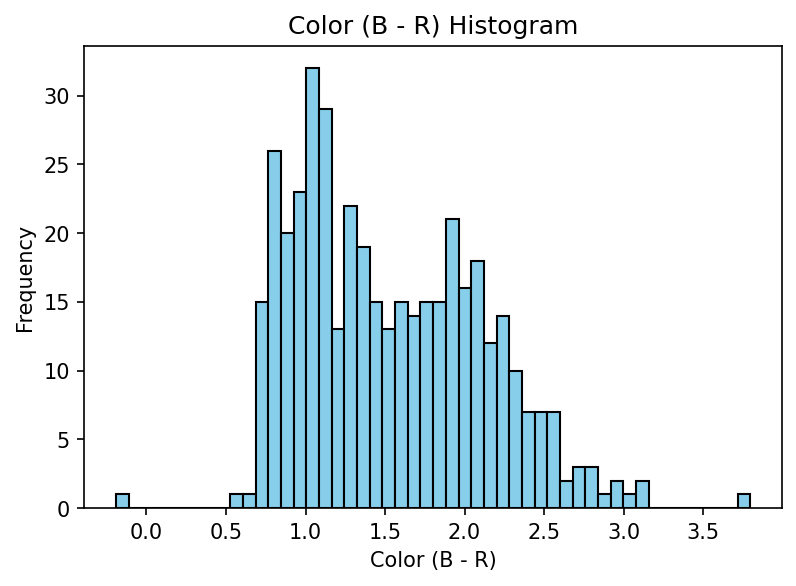

In [32]:
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']


# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution
plt.hist(color, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Color (B - R)')
plt.ylabel('Frequency')
plt.title('Color (B - R) Histogram')
plt.savefig('../figures/color_histogram.png', dpi=300)  # Save the plot as a PNG file
plt.show()

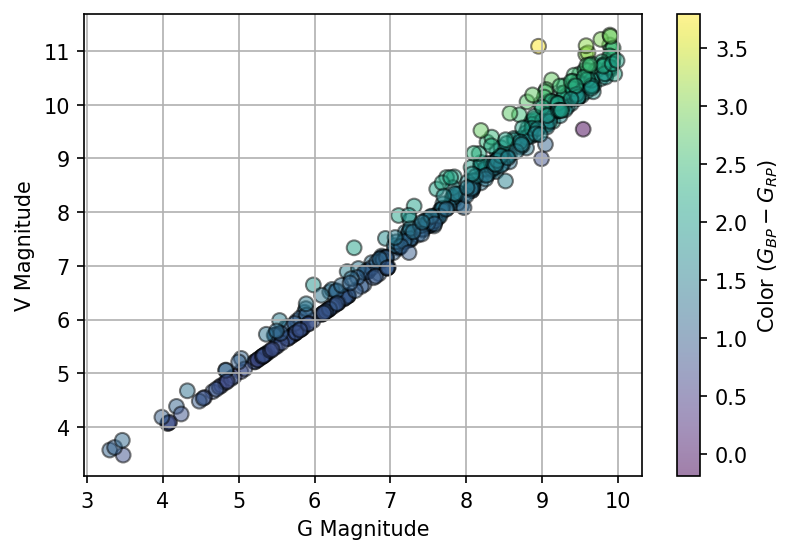

In [33]:

# Assuming 'color' is a column in combined_df or an array of the same length as the DataFrame
# For example, if 'color' is the difference between 'Phot BP Mean Mag' and 'Phot RP Mean Mag'
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']

# Calculate the conversion factor for colors between 1 and 4
conv = 0.20220 + 0.02489 * color

# Use np.where to apply the conversion conditionally
V_mag = np.where((color >= 1) & (color <= 4),
                 combined_df['Phot BP Mean Mag'] - conv,
                 combined_df['Phot G Mean Mag'])

# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution

# Plot the diagram using the color array for point colors
plt.scatter(combined_df['Phot G Mean Mag'], V_mag, c=color, cmap='viridis', edgecolor='k', s=50, alpha=0.5)
plt.xlabel('G Magnitude')
plt.ylabel('V Magnitude')
# plt.title('Color-Magnitude Diagram')
plt.colorbar(label='Color $(G_{BP} - G_{RP})$')
plt.grid()
plt.savefig('../figures/color_magnitude_diagram.png', dpi=300)
plt.show()


In [34]:
# List of columns to convert to numeric
columns_to_convert = ['T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]']

# Convert specified columns to numeric, coercing errors to NaN
for column in columns_to_convert:
    combined_df[column] = pd.to_numeric(combined_df[column], errors='coerce')

# Display the first few rows to verify the conversion
display(combined_df.head())

source_id        source_id_dr2        source_id_dr3          RA  \
0  6791154257817212672  6791154257817212672  6791154257817212672  319.937189   
1  4375233191015944192  4375233191015944192  4375233191015944192  261.435887   
3  4911306239828325760  4911306239828325760  4911306239828325760   24.950657   
4  4911306239828325632  4911306239828325632  4911306239828325632   24.951317   
5  5640565607657897728  5640565607657897728  5640565607657897728  128.208760   

         DEC  Phot G Mean Mag  Phot BP Mean Mag  Phot RP Mean Mag     BP-RP  \
0 -26.354449         6.445514          6.742600          5.773308  0.969292   
1   2.106158         6.934473          7.754755          6.047124  1.707631   
3 -56.196400         5.625487          6.089998          4.995800  1.094198   
4 -56.193251         5.508302          5.956992          4.886207  1.070785   
5 -31.497463         6.168385          6.567158          5.590500  0.976658   

     Parallax    T_eff [K]  Mass [M_Sun]  Luminosity [L_Sun]  Radius [R_Sun]  \
0   54.028805  5395.107623      0.900000            0.704693        1.040000   
1  129.645882  3920.000000      0.600000            0.187000        0.967000   
3  122.003472  4902.265000      0.826566            0.307352        0.748227   
4  122.108813  5044.240000      0.848425            0.330782        0.729474   
5   82.207993  5207.114000      0.879697            0.396505        0.781253   

  Spectral Type              HD Number              GJ Number HIP Number  \
0             F  HD 202940, HD 202940A  GJ 825.4 A, GJ 9734 A     105312   
1             K              HD 157881                 GJ 673      85295   
3             G              HD  10361                GJ 66 A        NaN   
4             G              HD  10360                GJ 66 B        NaN   
5             G              HD  72673                 GJ 309      41926   

  Object Type Spectral Type Simbad  
0         SB*                 None  
1     HighPM*                 None  
3     HighPM*                 None  
4     HighPM*                 None  
5     HighPM*                 None

In [35]:
# Insert the 'V_mag' column right after the 'DEC' column
combined_df.insert(combined_df.columns.get_loc('DEC') + 1, 'V_mag', V_mag)

if 'T_eff [K]' in combined_df.columns:

    # Calculate the HZ_limit
    hz_limits = combined_df.apply(lambda row: calculate_habitable_zone(row['T_eff [K]'], row['Luminosity [L_Sun]']), axis=1)
    # Find the index of the 'Radius [R_Sun]' column
    radius_index = combined_df.columns.get_loc('Radius [R_Sun]')
    # Insert the new column after 'Radius [R_Sun]'
    combined_df.insert(radius_index + 1, 'HZ_limit [AU]', hz_limits)
    # Sort the DataFrame by temperature (Teff)
    combined_df = combined_df.sort_values('T_eff [K]')    

# Export the combined DataFrame to an Excel file
combined_excel_file = 'combined_query.xlsx'
output_path = directory + combined_excel_file
combined_df.to_excel(output_path, index=False)

print(f"Combined results saved to {output_path}")
display(combined_df.head())

# Adjust the column widths
adjust_column_widths(output_path)

Combined results saved to ../results/combined_query.xlsx


source_id        source_id_dr2        source_id_dr3  \
44   6792436799475128960  6792436799475128960  6792436799475128960   
103  3195919254111314816  3195919322830293760  3195919254111314816   
201  2824770686019003904  2824770686019003904  2824770686019003904   
191  2976507997939000064  2976507997939000064  2976507997939000064   
227  1254694882149817728  1254694882149817728  1254694882149817728   

             RA        DEC      V_mag  Phot G Mean Mag  Phot BP Mean Mag  \
44   310.464334 -32.437037  10.938326         9.575837         11.215967   
103   63.829656  -7.670903  11.214272         9.775309         11.490885   
201  352.970124  19.936993  10.238880         9.043998         10.507311   
191   77.148374 -18.178273  10.280877         9.054890         10.550499   
227  216.448233  23.615502   9.955400         9.204846         10.207275   

     Phot RP Mean Mag     BP-RP  ...  Mass [M_Sun]  Luminosity [L_Sun]  \
44           8.184990  3.030977  ...          0.25             0.00842   
103          8.501209  2.989676  ...          0.25             0.00842   
201          7.846364  2.660946  ...          0.30             0.01420   
191          7.841693  2.708806  ...          0.30             0.01420   
227          8.211471  1.995805  ...          0.30             0.01780   

     Radius [R_Sun]  HZ_limit [AU]  Spectral Type   HD Number GJ Number  \
44           0.4105       0.098989              M  HD 196982A  GJ 799 A   
103          0.4105       0.098989              M        None  GJ 166 C   
201          0.4745       0.128289              M        None  GJ 896 A   
191          0.4745       0.128289              M        None    GJ 190   
227          0.5090       0.143499              M        None  GJ 548 B   

    HIP Number Object Type Spectral Type Simbad  
44         NaN     HighPM*                 None  
103        NaN   Eruptive*                 None  
201        NaN   Eruptive*                 None  
191      23932          **                 None  
227      70536     HighPM*                 None  

[5 rows x 22 columns]

In [36]:
from rv_prec import calculate_rv_precision

rv_precisions = []

for i in range(len(combined_df)):
    result, rv_precision = calculate_rv_precision(Temp=combined_df.iloc[i]['T_eff [K]'], Vmag=combined_df.iloc[i]['V_mag'])

    rv_precisions.append(rv_precision)

In [37]:
# Find the index of 'HZ_limit [AU]' column
hz_limit_index = combined_df.columns.get_loc('HZ_limit [AU]')

# Insert the rv_precisions to the right of 'HZ_limit [AU]'
combined_df.insert(hz_limit_index + 1, 'RV precision [m/s]', rv_precisions)

In [38]:
merged_df = combined_df.copy()

# Save the updated Excel file
output_path = directory + 'combined_query_with_RV_precision.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

### Calculate the HZ mass detection limit

In [39]:
from scipy import optimize

# Constants
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M_earth = 5.97e24  # Earth mass in kg
M_sun = 1.989e30  # Solar mass in kg
AU = 1.496e11  # 1 AU in meters

def calculate_hz_detection_limit(K, stellar_mass, orbital_radius):
    """
    Calculate the minimum detectable planet mass in the Habitable Zone.
    
    :param K: RV precision in m/s
    :param stellar_mass: Mass of the star in solar masses
    :param orbital_radius: Orbital radius (HZ limit) in AU
    :return: Minimum detectable planet mass in Earth masses or np.nan if calculation fails
    """
    try:
        stellar_mass_kg = stellar_mass * M_sun
        orbital_radius_m = orbital_radius * AU
        
        if K <= 0 or stellar_mass_kg <= 0 or orbital_radius_m <= 0:
            return np.nan
        
        def equation(m_p):
            return K - (G**(1/2) * orbital_radius_m**(-1/2) * m_p * (stellar_mass_kg + m_p)**(-1/2))
        
        # Use numerical method to solve the equation
        planet_mass_kg = optimize.brentq(equation, 0, stellar_mass_kg)
        
        return planet_mass_kg / M_earth
    except:
        return np.nan

# Apply the calculation to each row
merged_df['HZ Detection Limit [Earth Mass]'] = merged_df.apply(
    lambda row: calculate_hz_detection_limit(
        row['RV precision [m/s]'],
        row['Mass [M_Sun]'],
        row['HZ_limit [AU]']
    ),
    axis=1
)

# Print some statistics about the new column
print(merged_df['HZ Detection Limit [Earth Mass]'].describe())

# Count and print the number of NaN values
nan_count = merged_df['HZ Detection Limit [Earth Mass]'].isna().sum()
print(f"Number of NaN values: {nan_count}")

# Reorder the columns to place the new column next to 'Mass'
cols = merged_df.columns.tolist()
mass_index = cols.index('RV precision [m/s]')
cols.insert(mass_index + 1, cols.pop(cols.index('HZ Detection Limit [Earth Mass]')))
merged_df = merged_df[cols]

# Save the updated DataFrame
output_path = directory + 'combined_query_with_mass_detection_limit.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

print(f"Updated DataFrame saved to '{output_path}'.")


count    415.000000
mean       1.477886
std        2.841515
min        0.163124
25%        0.825801
50%        1.269491
75%        1.558430
max       51.424717
Name: HZ Detection Limit [Earth Mass], dtype: float64
Number of NaN values: 1
Updated DataFrame saved to '../results/combined_query_with_mass_detection_limit.xlsx'.


### Statistics and plots

In [40]:
print(merged_df.columns.tolist())

['source_id', 'source_id_dr2', 'source_id_dr3', 'RA', 'DEC', 'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP', 'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]', 'Spectral Type', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type', 'Spectral Type Simbad']


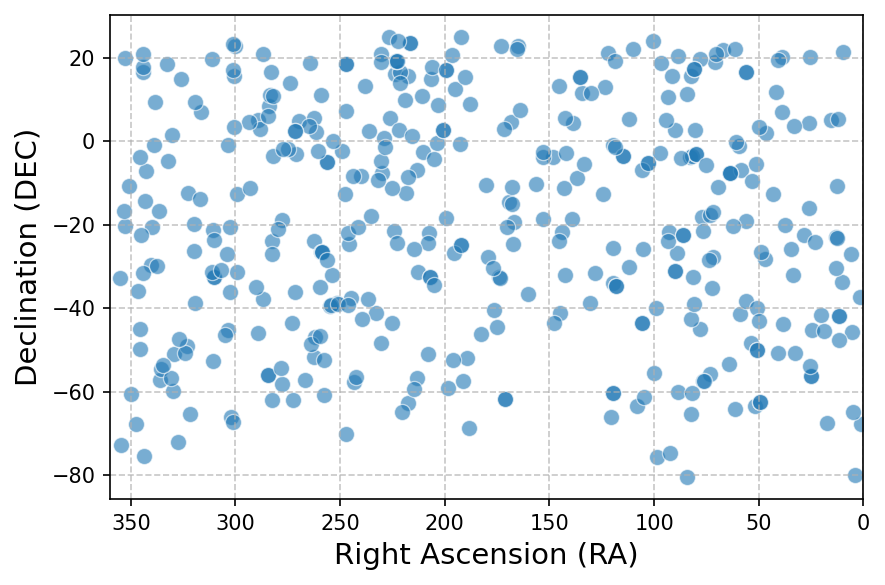

In [52]:
import seaborn as sns

def plot_scatter(x, y, data, xlabel, ylabel, xlim=None, ylim=None, filename=None, color=None, alpha=0.7, size=60, invert_xaxis=False, x2=None, y2=None, data2=None, color2=None, alpha2=0.7, size2=60):
    """Creates and saves a scatter plot with the given parameters, with an option to add a second group of data."""
    plt.figure(figsize=(6, 4), dpi=150)
    
    # Plot the first group of data
    if color is not None:
        sns.scatterplot(x=x, y=y, data=data, color=color, alpha=alpha, s=size)
    else:
        sns.scatterplot(x=x, y=y, data=data, alpha=alpha, s=size)

    # Plot the second group of data if provided
    if x2 is not None and y2 is not None and data2 is not None:
        if color2 is not None:
            sns.scatterplot(x=x2, y=y2, data=data2, color=color2, alpha=alpha2, s=size2)
        else:
            sns.scatterplot(x=x2, y=y2, data=data2, alpha=alpha2, s=size2)

    # Customize the plot
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    # Add a grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Invert x-axis if specified
    if invert_xaxis:
        plt.gca().invert_xaxis()

    # Customize tick labels
    plt.tick_params(axis='both', which='major')

    # Adjust layout and display the plot
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

# Use the function to create the RA vs DEC plot
plot_scatter(
    x='RA',
    y='DEC',
    data=merged_df,
    xlabel='Right Ascension (RA)',
    ylabel='Declination (DEC)',
    xlim=(0, 360),
    
    filename='../figures/ra_dec.png',
    alpha=0.6,
    invert_xaxis=True
)

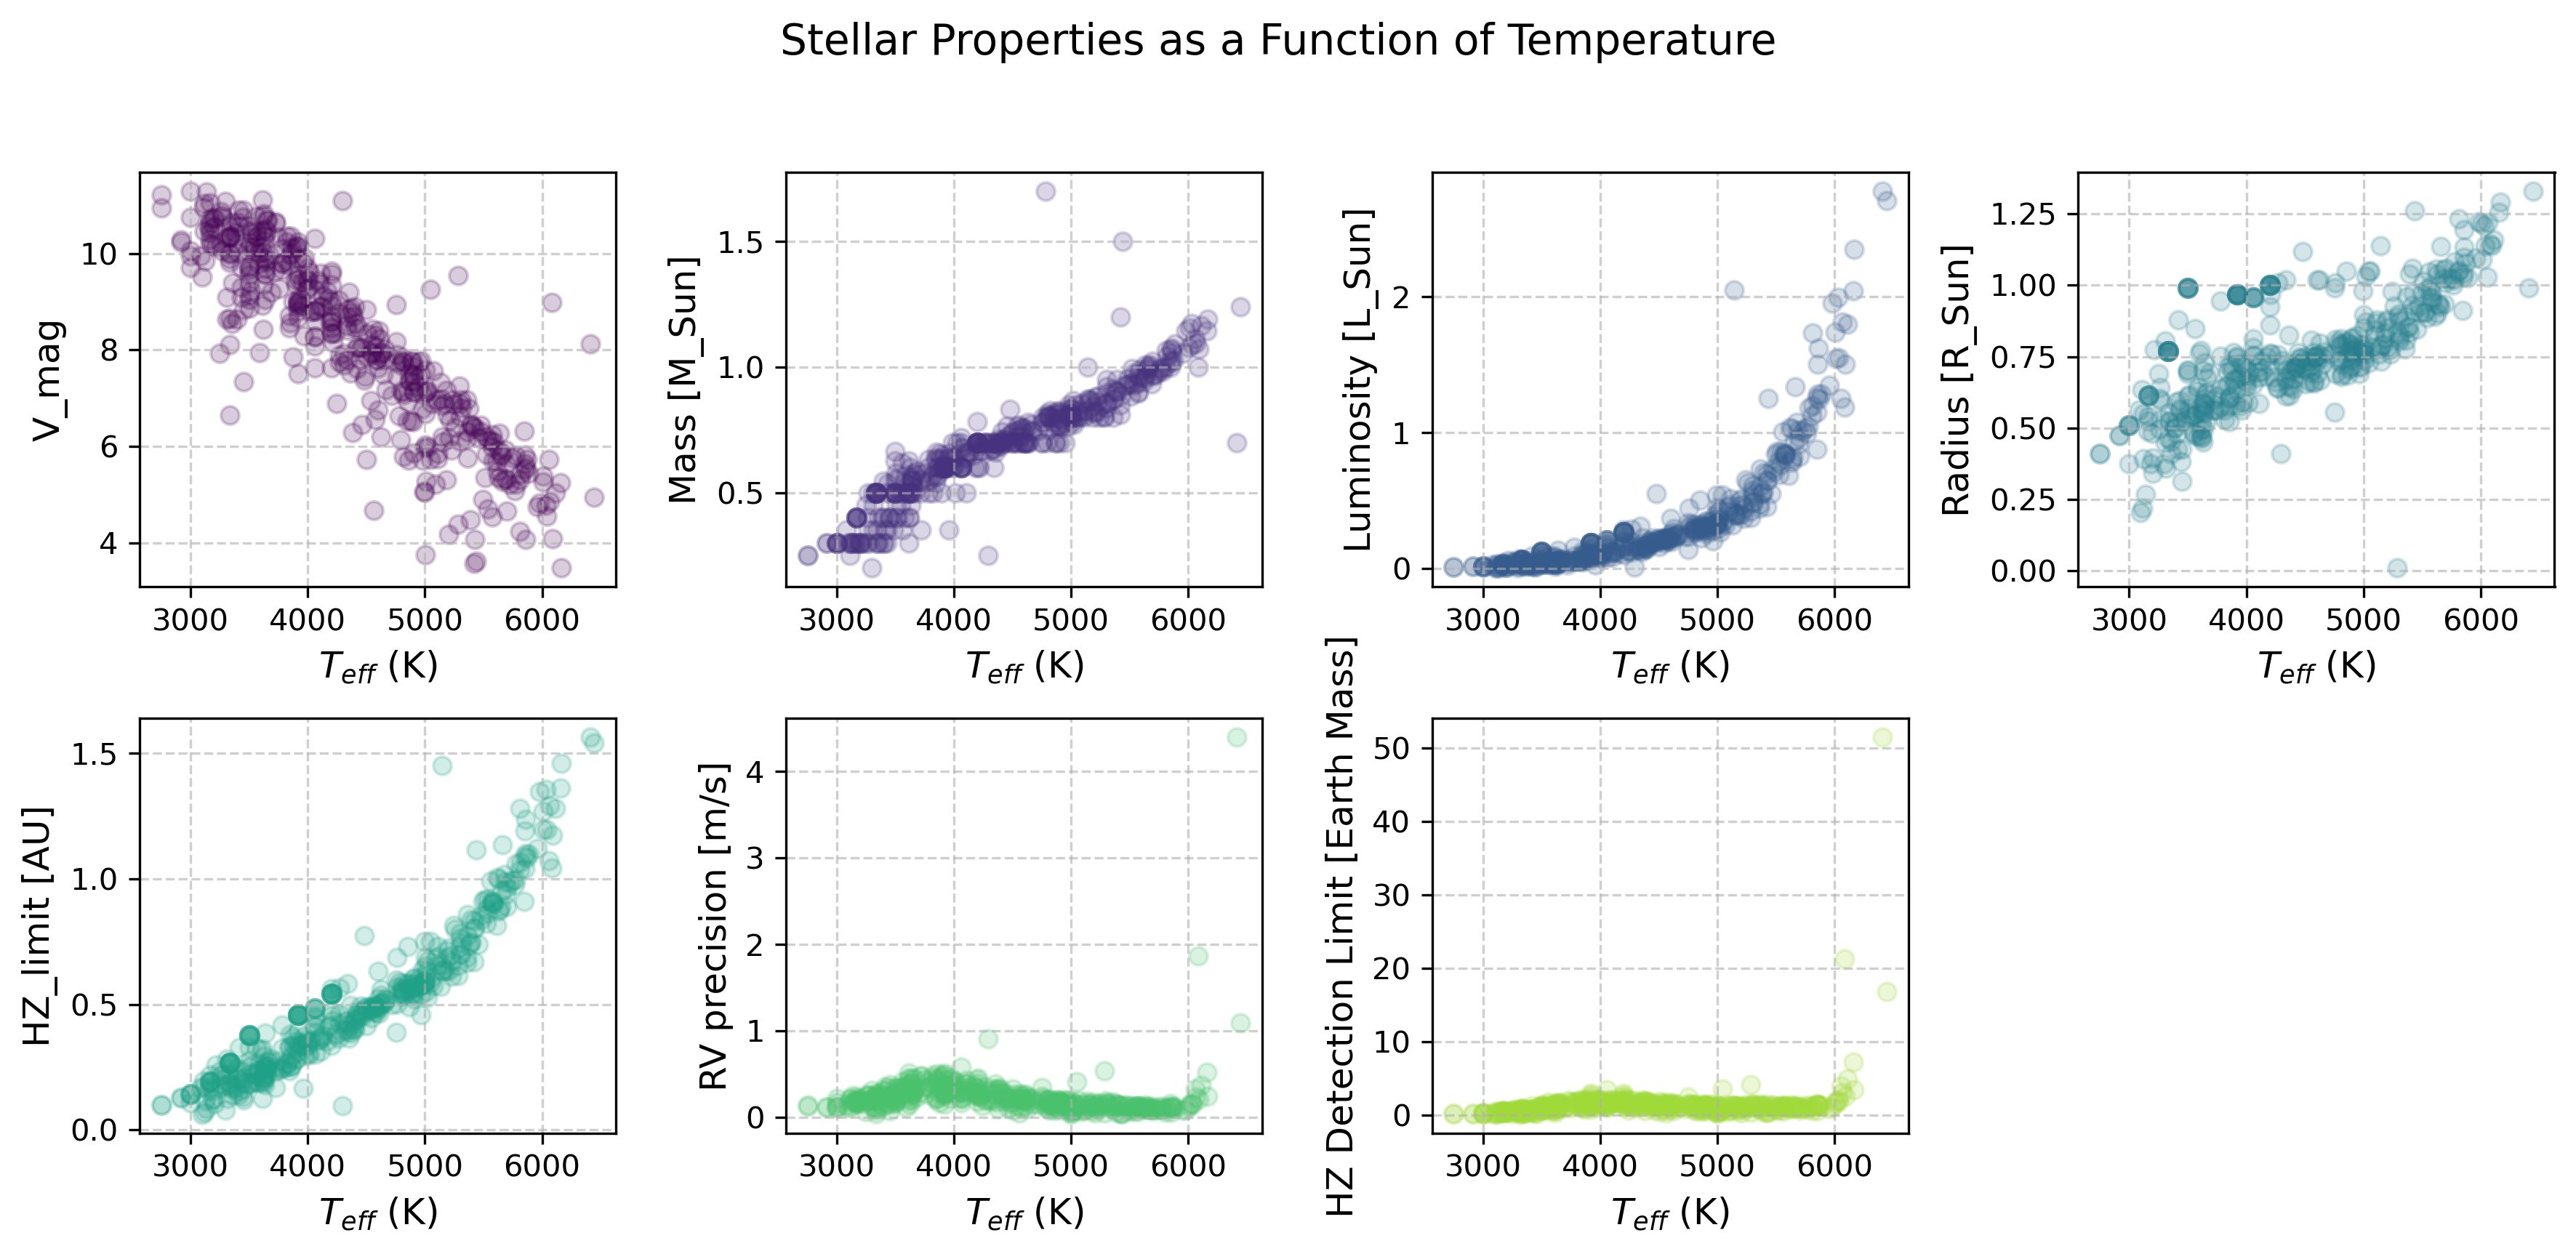

In [53]:
import matplotlib.pyplot as plt

# Create the plot
fig, axs = plt.subplots(2, 4, figsize=(12, 6), dpi=300)

# Flatten the axs array for easier iteration
axs = axs.flatten()

# List of columns to plot
columns = ['V_mag', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 
           'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]']

# Define a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(columns)+1))

# Plot each column
for i, col in enumerate(columns):
    axs[i].scatter(merged_df['T_eff [K]'], merged_df[col], alpha=0.2, color=colors[i])
    axs[i].set_xlabel('$T_{eff}$ (K)', fontsize=12)
    axs[i].set_ylabel(col, fontsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.6)

# Remove the last unused subplot
fig.delaxes(axs[-1])

# Add a main title
fig.suptitle('Stellar Properties as a Function of Temperature', fontsize=14)

# Adjust the layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figures/stellar_properties_vs_temperature.png')
plt.show()


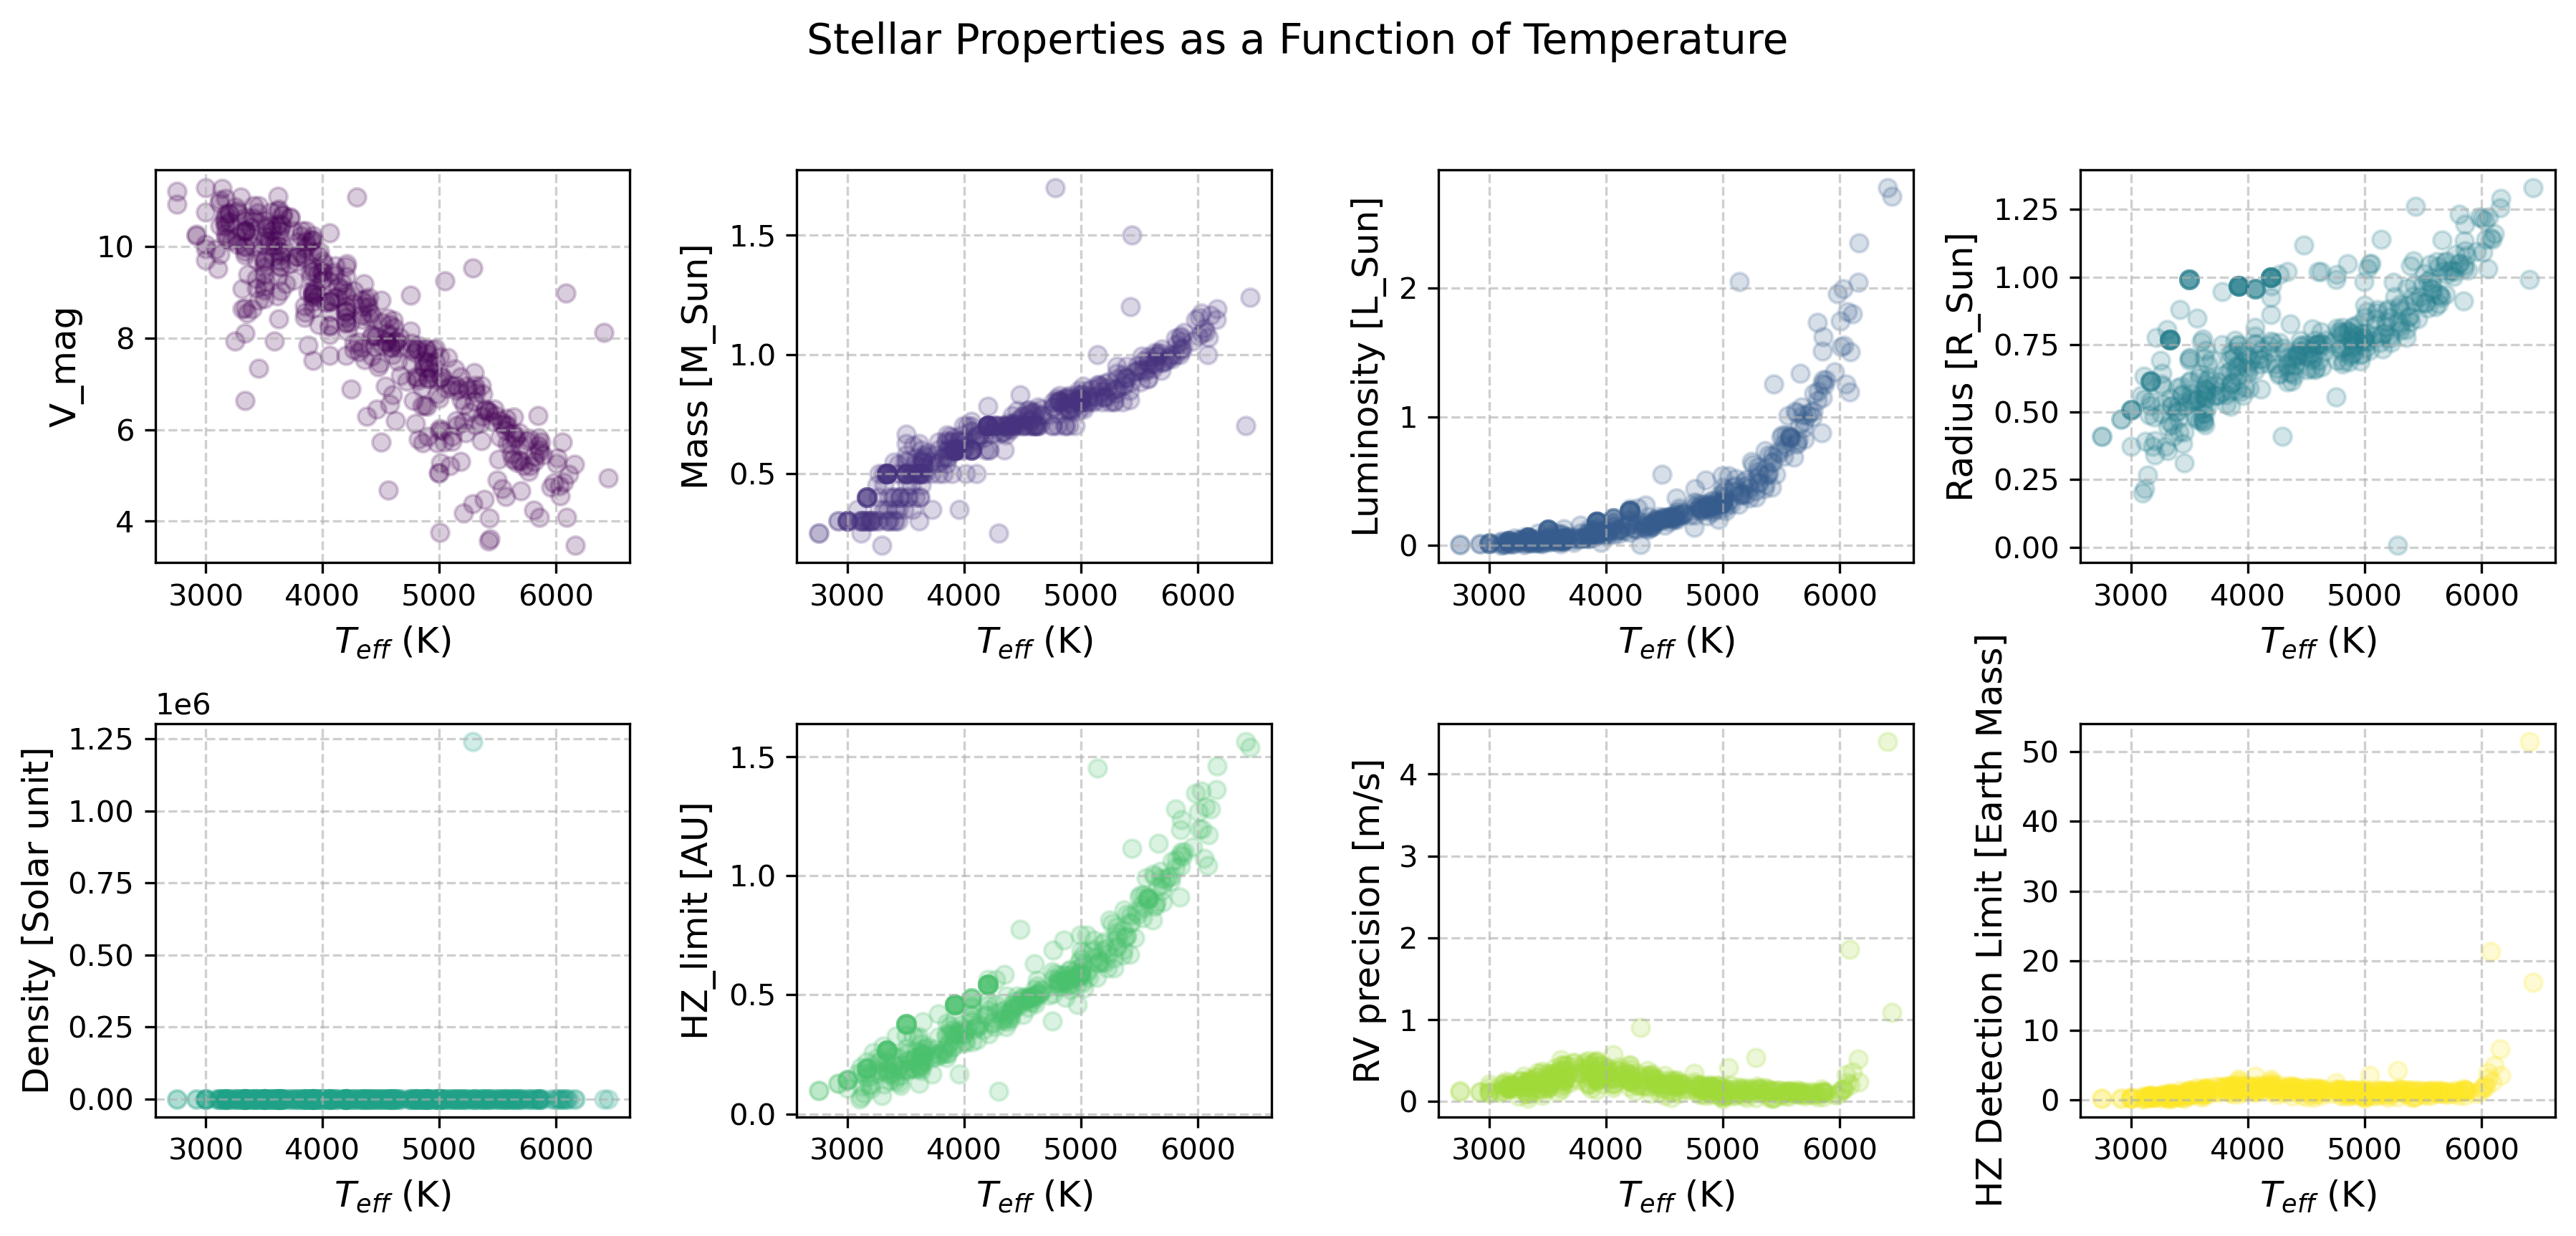

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate density and add it to the DataFrame
merged_df['Density [Solar unit]'] = merged_df['Mass [M_Sun]'] / (merged_df['Radius [R_Sun]'] ** 3)

# Create the plot
fig, axs = plt.subplots(2, 4, figsize=(12, 6), dpi=300)

# Flatten the axs array for easier iteration
axs = axs.flatten()

# List of columns to plot, including the new Density column
columns = [
    'V_mag', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 
    'Density [Solar unit]', 'HZ_limit [AU]', 'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]'
]

# Define a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(columns)))

# Plot each column
for i, col in enumerate(columns):
    axs[i].scatter(merged_df['T_eff [K]'], merged_df[col], alpha=0.2, color=colors[i])
    axs[i].set_xlabel('$T_{eff}$ (K)', fontsize=12)
    axs[i].set_ylabel(col, fontsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.6)

# Add a main title
fig.suptitle('Stellar Properties as a Function of Temperature', fontsize=14)

# Adjust the layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figures/stellar_properties_vs_temperature.png')
plt.show()


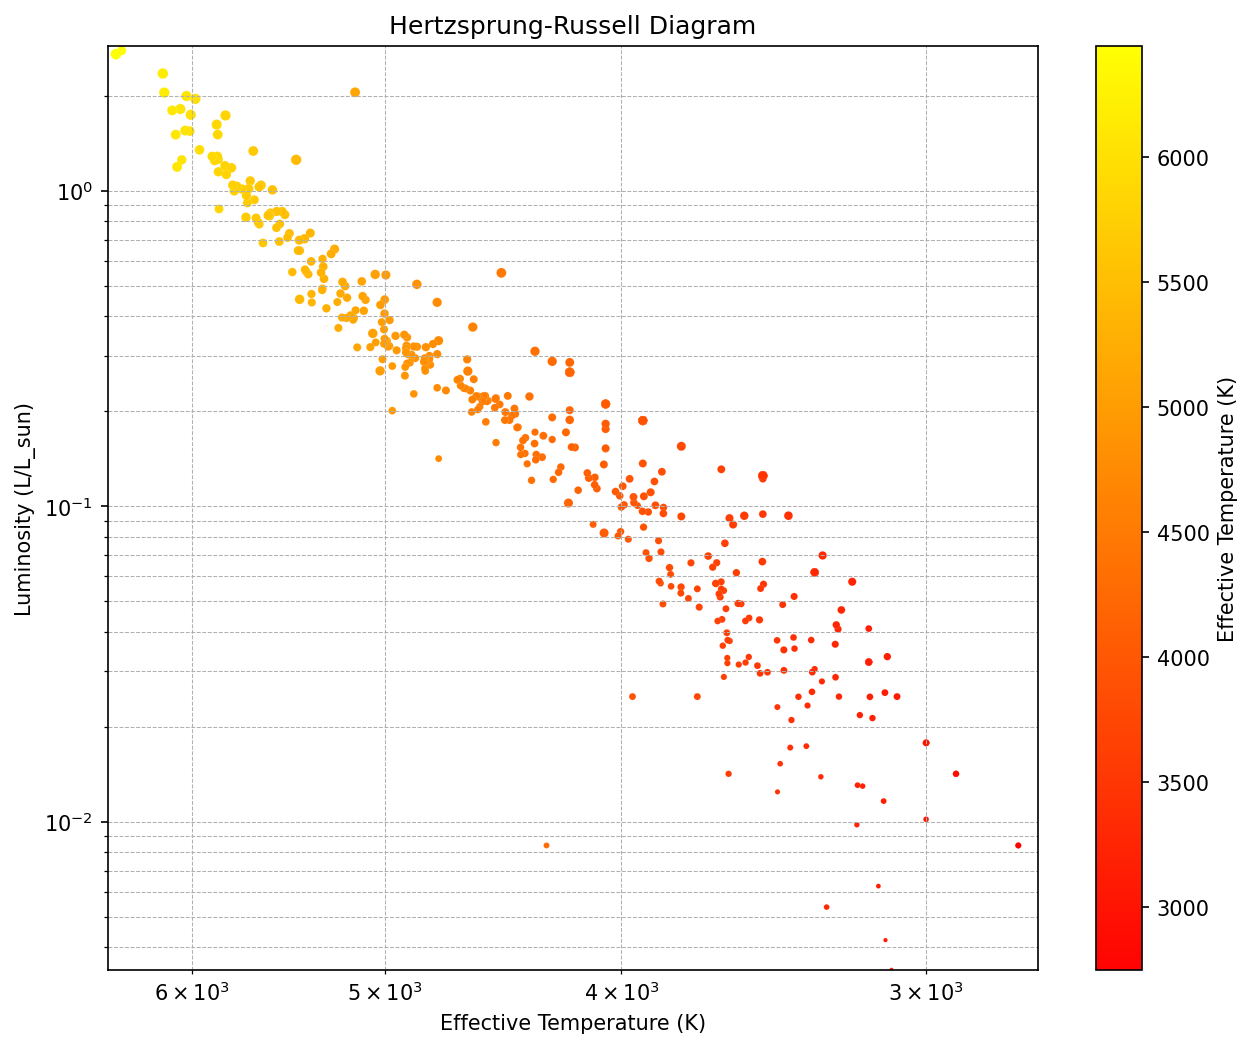

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame

# Plotting the H-R Diagram with color transition from red to yellow
plt.figure(figsize=(10, 8), dpi=150)
plt.scatter(
    merged_df['T_eff [K]'], 
    merged_df['Luminosity [L_Sun]'], 
    c=merged_df['T_eff [K]'],  # Color by temperature
    cmap='autumn',  # Use autumn colormap for red to yellow transition
    alpha=0.99, 
    edgecolors='w',  # Use white for edges
    linewidths=0.05,  # Set edge width
    s=merged_df['Radius [R_Sun]'] * 20  # Scale the radius for visibility
)
plt.colorbar(label='Effective Temperature (K)')  # Add color bar
plt.xscale('log')
plt.yscale('log')
plt.xlim(min(merged_df['T_eff [K]'])-50, max(merged_df['T_eff [K]'])+50)  # Set the same x range
plt.ylim(min(merged_df['Luminosity [L_Sun]']), max(merged_df['Luminosity [L_Sun]'])+0.1)  # Set the same y range
plt.gca().invert_xaxis()  # Invert x-axis for temperature
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Luminosity (L/L_sun)')
plt.title('Hertzsprung-Russell Diagram')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig('../figures/HR_diagram.png')
plt.show()


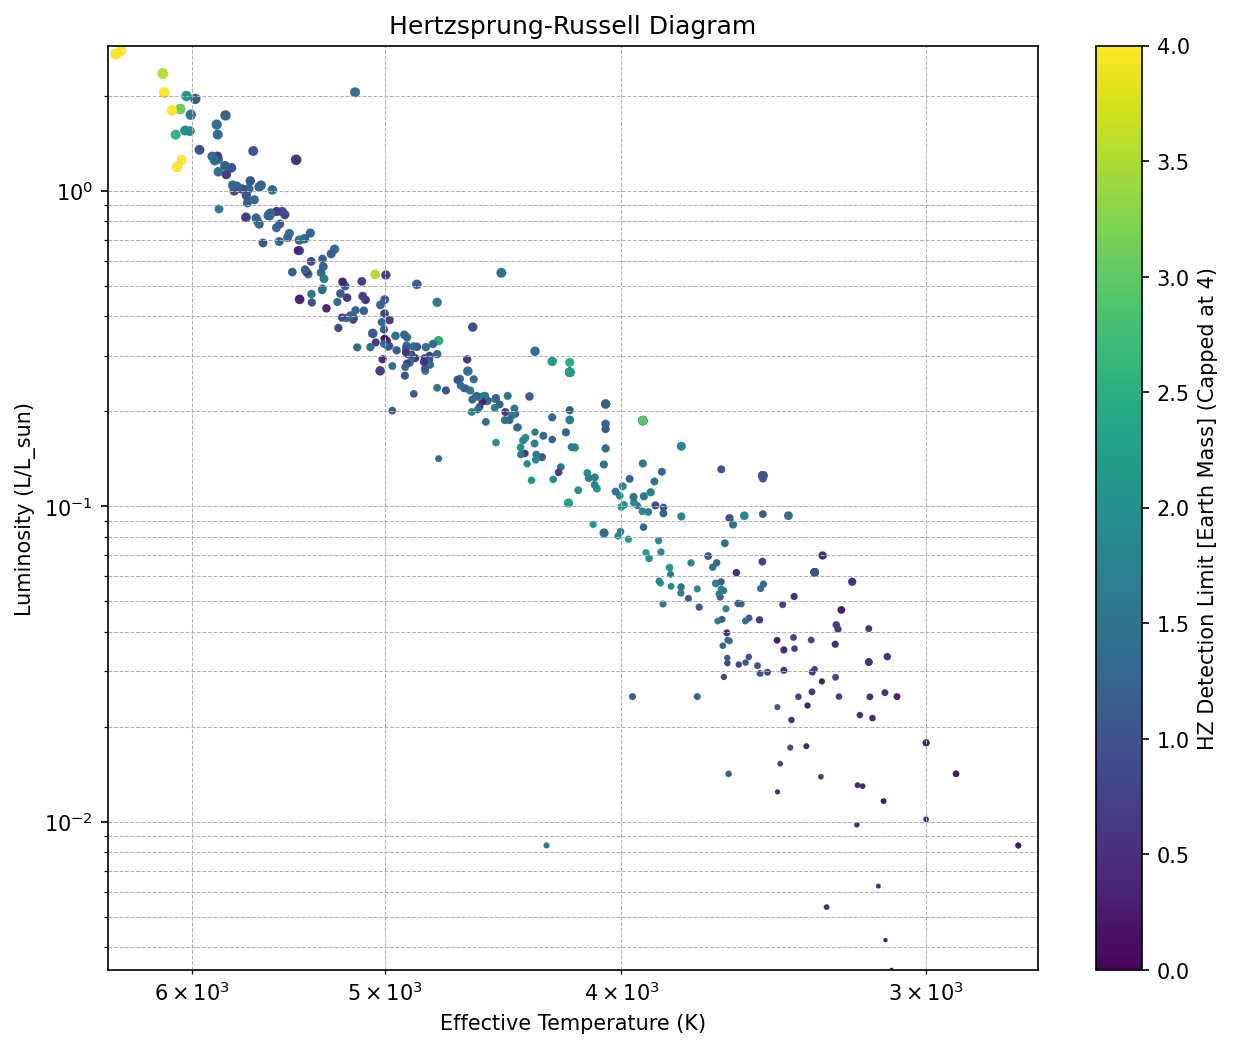

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame

# Option to switch between original and filtered plot
use_filtered_data = False  # Set to False to use the original data

if use_filtered_data:
    # Filter the DataFrame to include only rows where 'HZ Detection Limit [Earth Mass]' is less than 1.5
    data_to_plot = merged_df[merged_df['HZ Detection Limit [Earth Mass]'] <= 4]
    color_data = data_to_plot['HZ Detection Limit [Earth Mass]']
    colorbar_label = 'HZ Detection Limit [Earth Mass]'
    filename = '../figures/HR_diagram_HZ_detection_limit_filtered.png'
else:
    # Use the original data with capped values
    data_to_plot = merged_df
    color_data = np.minimum(merged_df['HZ Detection Limit [Earth Mass]'], 4)
    colorbar_label = 'HZ Detection Limit [Earth Mass] (Capped at 4)'
    filename = '../figures/HR_diagram_HZ_detection_limit.png'

# Plotting the H-R Diagram without gradient background and with color-coded circles by HZ Detection Limit
plt.figure(figsize=(10, 8), dpi=150)

# Scatter plot with circles color-coded by HZ Detection Limit
sc = plt.scatter(
    data_to_plot['T_eff [K]'], 
    data_to_plot['Luminosity [L_Sun]'], 
    c=color_data,  # Use appropriate color data
    cmap='viridis',  # Use viridis colormap for detection limit
    alpha=0.99, 
    edgecolors='grey',  # Use grey for edges
    linewidths=0.05,  # Set edge width
    s=data_to_plot['Radius [R_Sun]'] * 20  # Scale the radius for visibility
)

# Add a color bar with the same scaling
cbar = plt.colorbar(sc, label=colorbar_label)
sc.set_clim(0, 4)  # Set color bar limits to maintain the same scaling

plt.xscale('log')
plt.yscale('log')
plt.xlim(min(merged_df['T_eff [K]'])-50, max(merged_df['T_eff [K]'])+50)  # Set the same x range
plt.ylim(min(merged_df['Luminosity [L_Sun]']), max(merged_df['Luminosity [L_Sun]'])+0.1)  # Set the same y range
plt.gca().invert_xaxis()  # Invert x-axis for temperature
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Luminosity (L/L_sun)')
plt.title('Hertzsprung-Russell Diagram')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig(filename)
plt.show()


In [55]:
merged_df['RV precision [m/s]']

44     0.121143
103    0.137558
201    0.114845
191    0.117088
227    0.114750
         ...   
43     0.366237
315    0.522904
83     0.241112
69     4.396188
70     1.092344
Name: RV precision [m/s], Length: 416, dtype: float64

In [63]:
if 1:
    # Update the DataFrame with stellar properties
    merged_result_with_properties = get_stellar_properties_from_gaia(merged_result)
    merged_result_with_properties

    # Save to Excel
    filename = directory + 'merged_result_MJ_with_properties.xlsx'
    merged_result_with_properties.to_excel(filename, index=False)
    adjust_column_widths(filename)

3 2452378776434477184 G8V G8V
26 6080301367488384896 K9Vk: K9V
16 5994771148252505216 K4V K4V
17 5378886891123024512 K4.5Vk: K4.5V
K4V K5V
21 4737533237421005952 K3.5V K3.5V
K3V K4V
22 5285775539195330560 K6Vk: K6V
23 4833654227548585856 K5/M0V K5/M0V
K5V M0V
35 4673947174316727040 K4.5V K4.5V
K4V K5V
39 4377160604838377600 K3-V K3V
29 1736838805468812160 K6V K6V
32 6288325222245417856 K6Va K6V
38 6742873637093574400 G2V G2V
30 4258375617747092864 K5V K5V
43 6029992663310612096 K0IV-V K0IV-V
K0IV K0V
51 6832674634380238848 K6.5Vk K6.5V
K6V K7V
40 5117974602912370432 G8V G8V
64 6427464123776727168 G8IV G8IV
41 5412947081295024896 K6Vk: K6V
44 6313600142709958144 K8Vk K8V
56 6232511606838403968 K4V K4V
65 6190970236474307200 G5Va G5V
60 4072260704719970944 K8Vk K8V
101 3372159045216183552 K2Ve K2V
66 3211461469444773376 K3+V K3V
91 2552288133874677760 K2V K2V
100 6863535898551993472 K3VaCN1 K3V
73 3210731015768096000 K5V K5V
80 3812355294262255104 K3 K3
-- No data found for stellar type 

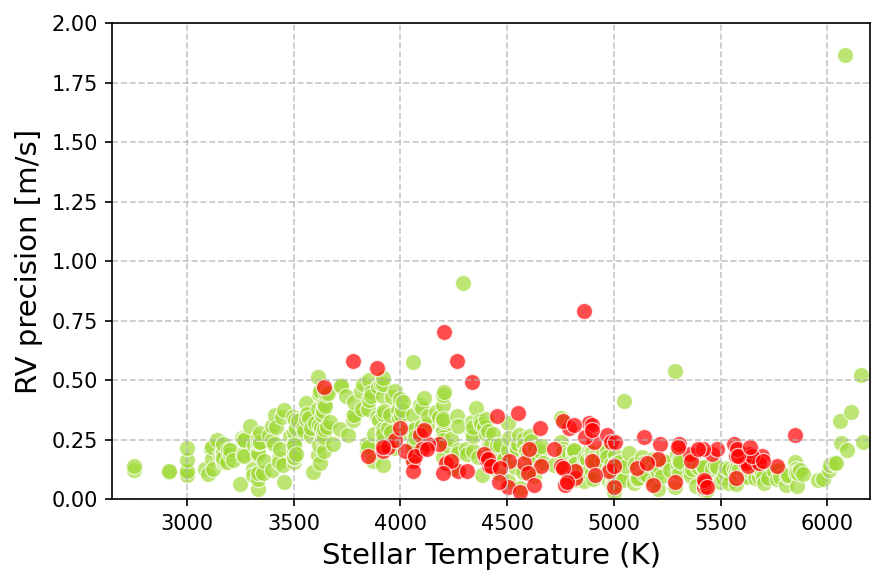

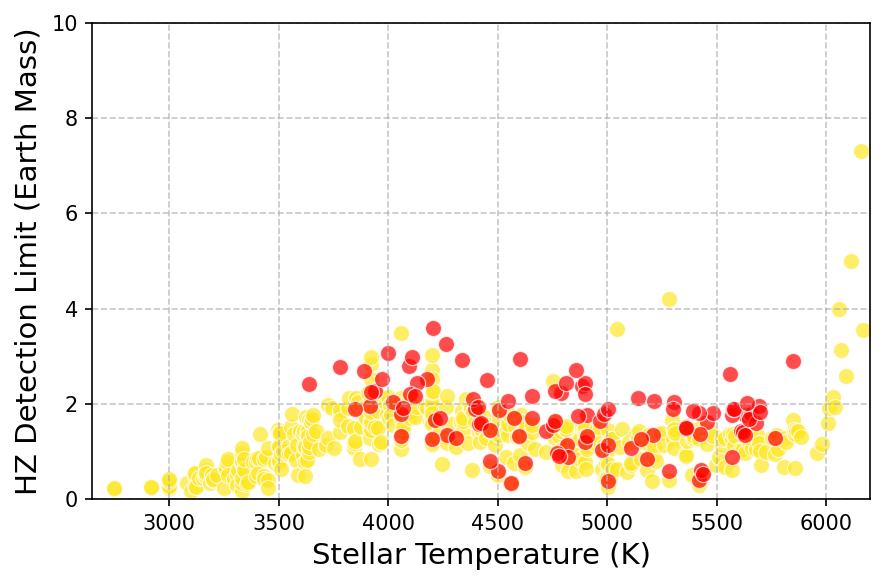

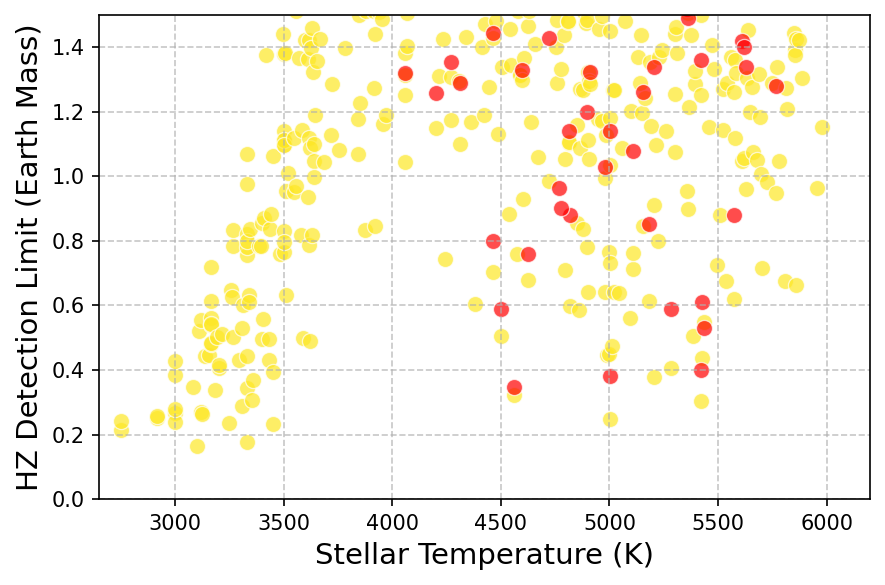

In [64]:
# Use the function to create the plot
plot_scatter(
    x='T_eff [K]',
    y='RV precision [m/s]',
    data=merged_df,
    xlabel='Stellar Temperature (K)',
    ylabel='RV precision [m/s]',
    xlim=(min(merged_df['T_eff [K]']) - 100, 6000 + 200),
    ylim=(0, 2),
    filename='../figures/RV_precision_vs_temperature.png',
    color=colors[i-1],  # Assuming 'colors' is defined and 'i' is an integer index
    x2 = 'T_eff [K]', 
    y2 = 'Reiners RV precision',
    data2 = merged_result_with_properties,
    color2 = 'red'
)

plot_scatter(
    x='T_eff [K]',
    y='HZ Detection Limit [Earth Mass]',
    data=merged_df,
    xlabel='Stellar Temperature (K)',
    ylabel='HZ Detection Limit (Earth Mass)',
    xlim=(min(merged_df['T_eff [K]']) - 100, 6000 + 200),
    ylim=(0, 10),
    filename='../figures/HZ_detection_limit_vs_temperature_full.png',
    color=colors[i],  # Replace with actual color if using a list
    x2 = 'T_eff [K]', 
    y2 = 'Reiners HZ Me limit',
    data2 = merged_result_with_properties,
    color2 = 'red'
)

plot_scatter(
    x='T_eff [K]',
    y='HZ Detection Limit [Earth Mass]',
    data=merged_df,
    xlabel='Stellar Temperature (K)',
    ylabel='HZ Detection Limit (Earth Mass)',
    xlim=(min(merged_df['T_eff [K]']) - 100, 6000 + 200),
    ylim=(0, 1.5),
    filename='../figures/HZ_detection_limit_vs_temperature_zoomed.png',
    color=colors[i],  # Replace with actual color if using a list
    x2 = 'T_eff [K]', 
    y2 = 'Reiners HZ Me limit',
    data2 = merged_result_with_properties,
    color2 = 'red'
)


In [65]:
len(merged_df), len(merged_df[merged_df['HZ Detection Limit [Earth Mass]']<4]), len(merged_df[merged_df['HZ Detection Limit [Earth Mass]']<1.5]), len(merged_result_with_properties), len(merged_result_with_properties[merged_result_with_properties['Reiners HZ Me limit']<4]), len(merged_result_with_properties[merged_result_with_properties['Reiners HZ Me limit']<1.5])

(416, 409, 297, 107, 107, 37)

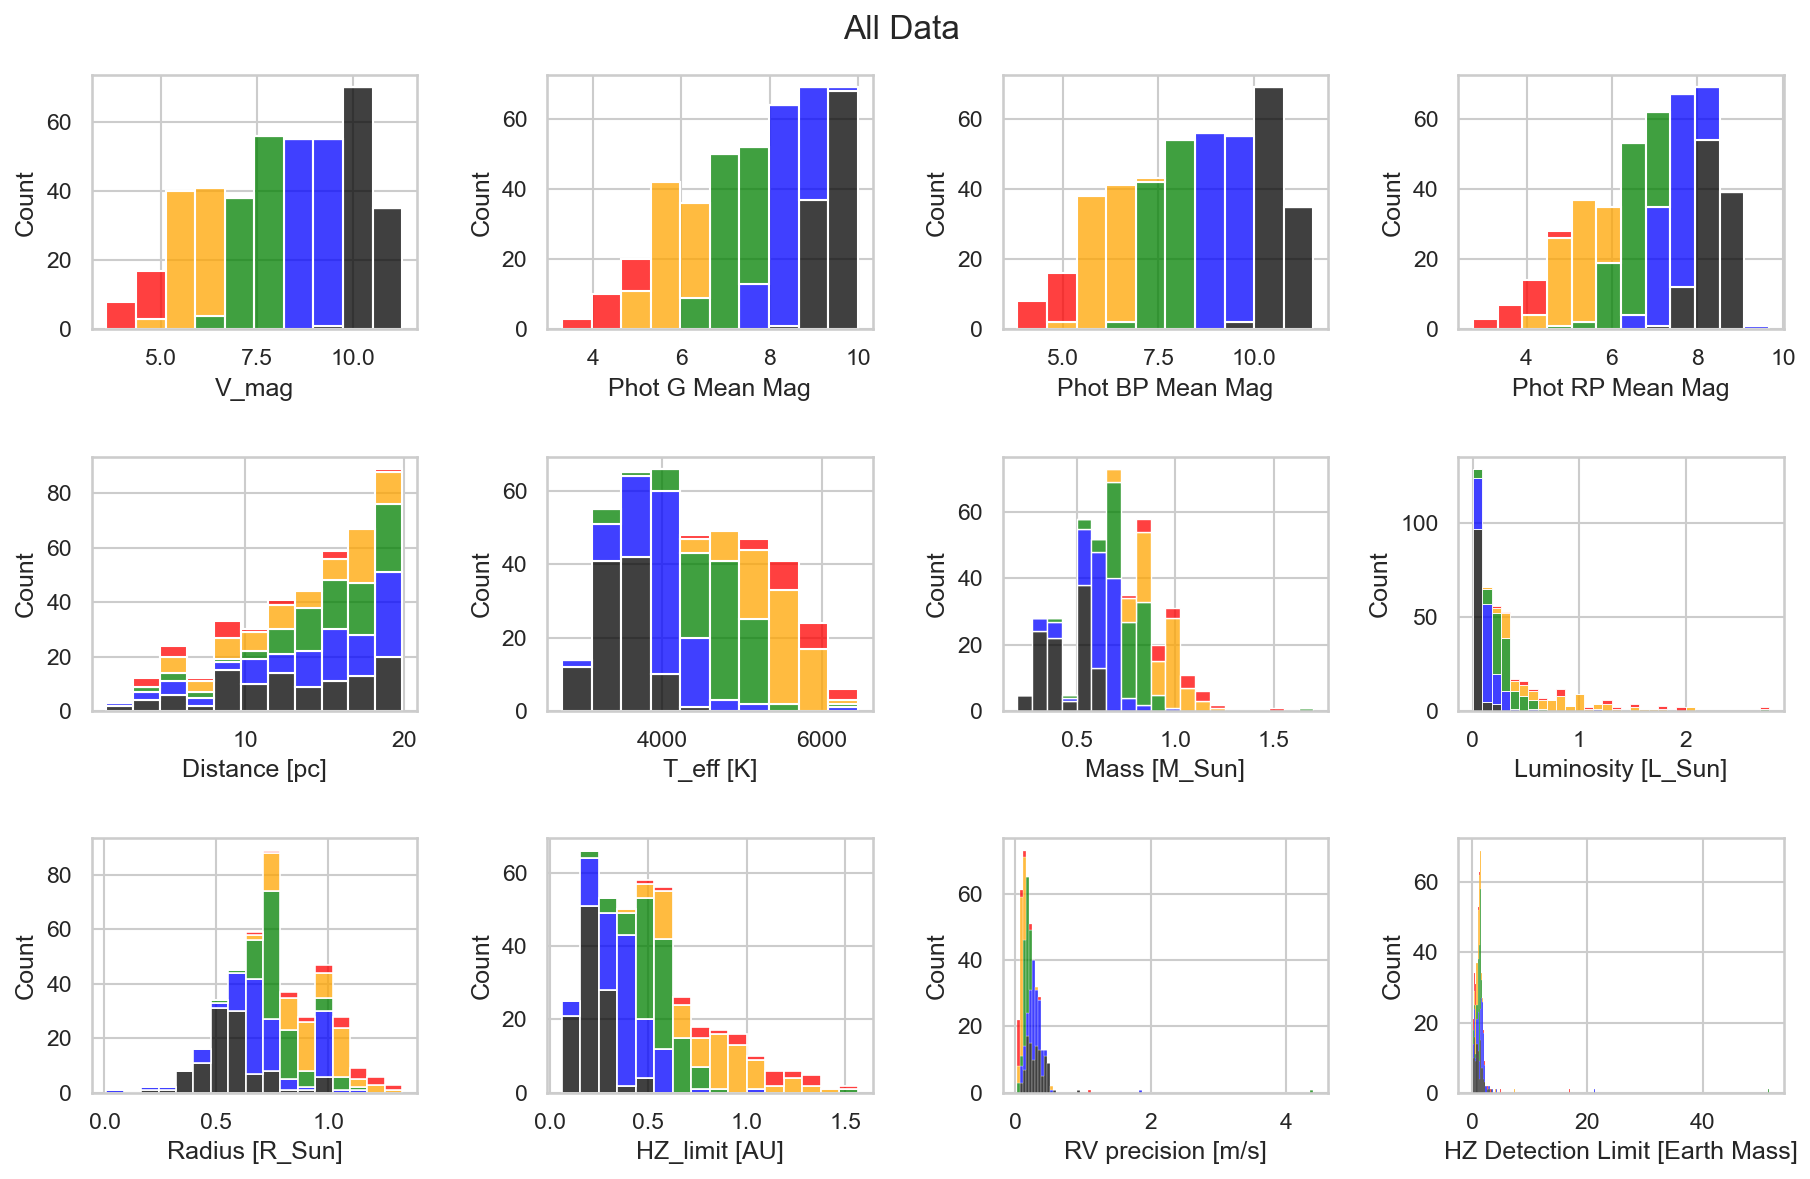

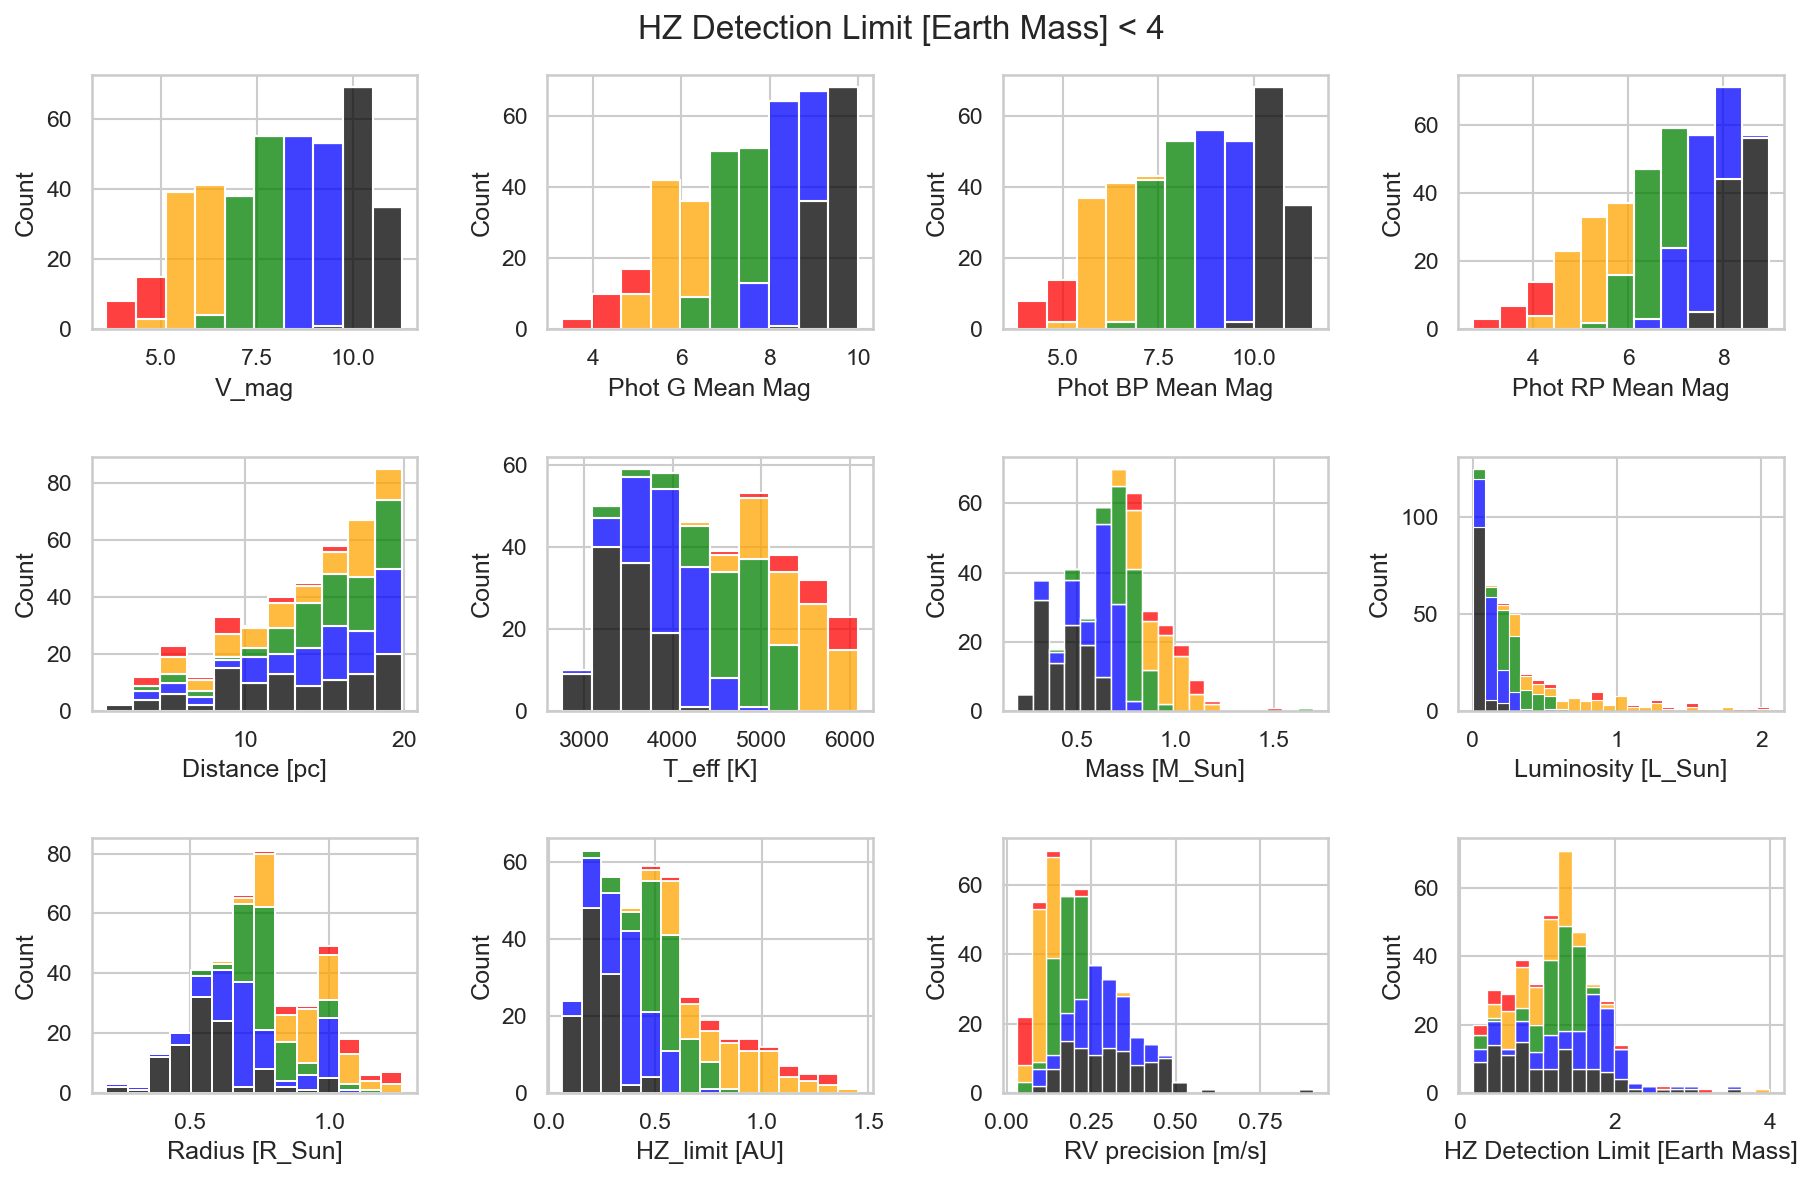

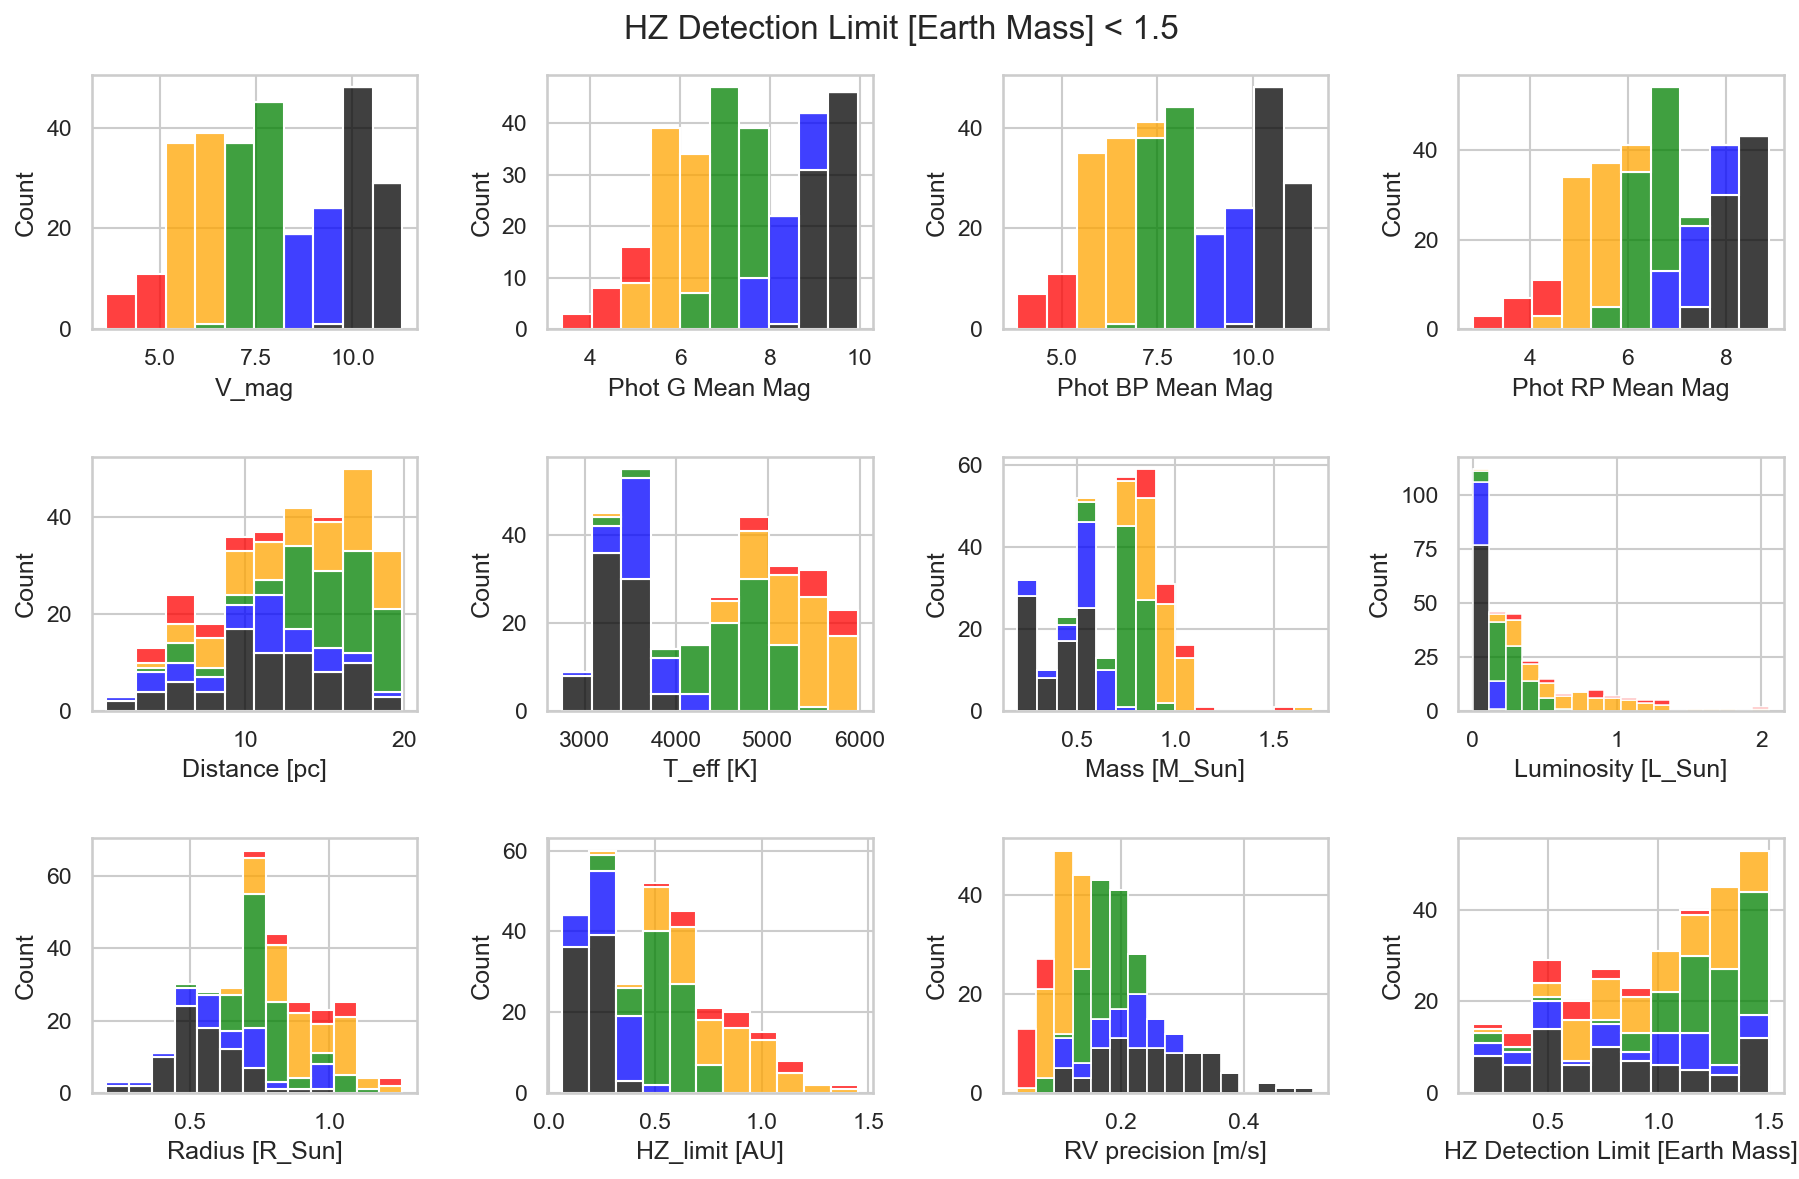

In [66]:
# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Calculate distance and add it to the DataFrame
merged_df['Distance [pc]'] = 1000 / merged_df['Parallax']

# List of columns to plot
columns_to_plot = [
    'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag',
    'Distance [pc]', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 
    'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]'
]

# Define reversed grayscale colors for each group
group_colors = {
    'Brightest': 'red',
    'Bright': 'orange',
    'Dim': 'green',
    'Dimmer': 'blue',
    'Dimmest': 'black'
}

def plot_histograms(df, title, filename):
    # Divide V_mag into 5 groups and assign reversed grayscale colors
    v_mag_bins = np.linspace(df['V_mag'].min(), df['V_mag'].max(), 6)
    df['V_mag_group'] = pd.cut(df['V_mag'], bins=v_mag_bins, labels=group_colors.keys())

    # Set up the plot
    fig, axes = plt.subplots(3, 4, figsize=(12, 8), dpi=150)
    fig.suptitle(title, fontsize=16)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Create histograms with color coding
    for i, column in enumerate(columns_to_plot):
        if column in df.columns:
            sns.histplot(data=df, x=column, ax=axes[i], hue='V_mag_group', palette=group_colors, multiple='stack', legend=False)
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Count')
        else:
            axes[i].set_visible(False)  # Hide axes if column is not available

    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.5, wspace=0.4, left=0.05, right=0.99)
    plt.savefig(filename)
    plt.show()

# Plot for the entire DataFrame
plot_histograms(merged_df, 'All Data', '../figures/star_properties_histograms.png')

# Plot for HZ Detection Limit < 4
filtered_df_4 = merged_df[merged_df['HZ Detection Limit [Earth Mass]'] < 4].copy()
plot_histograms(filtered_df_4, 'HZ Detection Limit [Earth Mass] < 4', '../figures/star_properties_histograms_filtered_4.png')

# Plot for HZ Detection Limit < 1.5
filtered_df_1_5 = merged_df[merged_df['HZ Detection Limit [Earth Mass]'] < 1.5].copy()
plot_histograms(filtered_df_1_5, 'HZ Detection Limit [Earth Mass] < 1.5', '../figures/star_properties_histograms_filtered_1_5.png')


In [232]:
if 0: 
    # Create the 'source_id' column
    merged_df['source_id'] = np.where(merged_df['dr2_source_id'].notna(), merged_df['dr2_source_id'], merged_df['dr3_source_id'])

    # Move the 'source_id' column to the first position
    columns = ['source_id'] + [col for col in merged_df if col != 'source_id']
    merged_df = merged_df[columns]

    # Display the first few rows to verify the changes
    display(merged_df.head())

In [58]:
# read SEI_target_selection.xlsx file into a pandas DataFrame
import pandas as pd
df_Melissa = pd.read_excel('../data/SEI_target_selection.xlsx')
df_Melissa['Gaia name'] = df_Melissa['Gaia name'].astype(str)

In [59]:
len(df_Melissa), len(merged_df)

(107, 416)

In [60]:
if 0:
    merge_on_dr2 = pd.merge(df_Melissa, merged_df, left_on='Gaia name', right_on='source_id_dr2', how='left')

    # Then, perform the merge on 'source_id_dr3'
    merge_on_dr3 = pd.merge(df_Melissa, merged_df, left_on='Gaia name', right_on='source_id_dr3', how='left')

    # Concatenate the two results and drop duplicates if necessary
    merged_result = pd.concat([merge_on_dr2, merge_on_dr3]).drop_duplicates()

    # Optionally, you can reset the index if needed
    merged_result.reset_index(drop=True, inplace=True)

    filename = directory + 'test_merged_result_MJ.xlsx'
    merged_result.to_excel(filename, index=False)
    adjust_column_widths(filename)

    len(merged_result)

In [73]:
# Merge on 'source_id_dr2' and 'source_id_dr3'
merge_on_dr2 = pd.merge(df_Melissa, merged_df, left_on='Gaia name', right_on='source_id_dr2', how='left')
merge_on_dr3 = pd.merge(df_Melissa, merged_df, left_on='Gaia name', right_on='source_id_dr3', how='left')

# Concatenate the two results
merged_result = pd.concat([merge_on_dr2, merge_on_dr3])

# Add a column to count non-missing values in each row
merged_result['non_missing_count'] = merged_result.notna().sum(axis=1)

# Sort by 'Gaia name' and 'non_missing_count' in descending order
merged_result_sorted = merged_result.sort_values(by=['Gaia name', 'non_missing_count'], ascending=[True, False])

# Drop duplicates, keeping the first occurrence (most complete row)
merged_result_unique = merged_result_sorted.drop_duplicates(subset='Gaia name', keep='first')

# Drop the auxiliary column used for sorting
merged_result_unique = merged_result_unique.drop(columns=['non_missing_count'])

# Sort the final results by the column "suitable"
merged_result_final = merged_result_unique.sort_values(by='suitable')

# Convert the values in column "Gaia name.1" to strings
merged_result_final['Gaia name.1'] = merged_result_final['Gaia name.1'].astype(str)

# Display the number of unique rows and the result
num_unique_rows = len(merged_result_final)

num_unique_rows

merged_result = merged_result_final.copy()

filename = directory + 'test_merged_result_MJ.xlsx'
merged_result.to_excel(filename, index=False)
adjust_column_widths(filename)

In [69]:
if 0:

    # Merge on 'source_id_dr2' and 'source_id_dr3'
    merge_on_dr2 = pd.merge(df_Melissa, df_consolidated_HD, left_on='Gaia name', right_on='source_id_dr2', how='left')
    merge_on_dr3 = pd.merge(df_Melissa, df_consolidated_HD, left_on='Gaia name', right_on='source_id_dr3', how='left')

    # Concatenate the two results
    merged_result = pd.concat([merge_on_dr2, merge_on_dr3])

    # Add a column to count non-missing values in each row
    merged_result['non_missing_count'] = merged_result.notna().sum(axis=1)

    # Sort by 'Gaia name' and 'non_missing_count' in descending order
    merged_result_sorted = merged_result.sort_values(by=['Gaia name', 'non_missing_count'], ascending=[True, False])

    # Drop duplicates, keeping the first occurrence (most complete row)
    merged_result_unique = merged_result_sorted.drop_duplicates(subset='Gaia name', keep='first')

    # Drop the auxiliary column used for sorting
    merged_result_unique = merged_result_unique.drop(columns=['non_missing_count'])

    # Sort the final results by the column "suitable"
    merged_result_final = merged_result_unique.sort_values(by='suitable')

    # Convert the values in column "Gaia name.1" to strings
    merged_result_final['Gaia name.1'] = merged_result_final['Gaia name.1'].astype(str)

    # Display the number of unique rows and the result
    num_unique_rows = len(merged_result_final)

    num_unique_rows

    merged_result = merged_result_final.copy()

    filename = directory + 'merged_result_MJ_df_consolidated_HD.xlsx'
    merged_result.to_excel(filename, index=False)
    adjust_column_widths(filename)

In [252]:
if 0:
    merged_result = df_Melissa.merge(merged_df, left_on="Gaia name", right_on="source_id", how="inner", suffixes=('_M', '_J'))
    filename = directory + 'merged_result_MJ.xlsx'
    merged_result.to_excel(filename, index=False)
    adjust_column_widths(filename)

    len(merged_result)

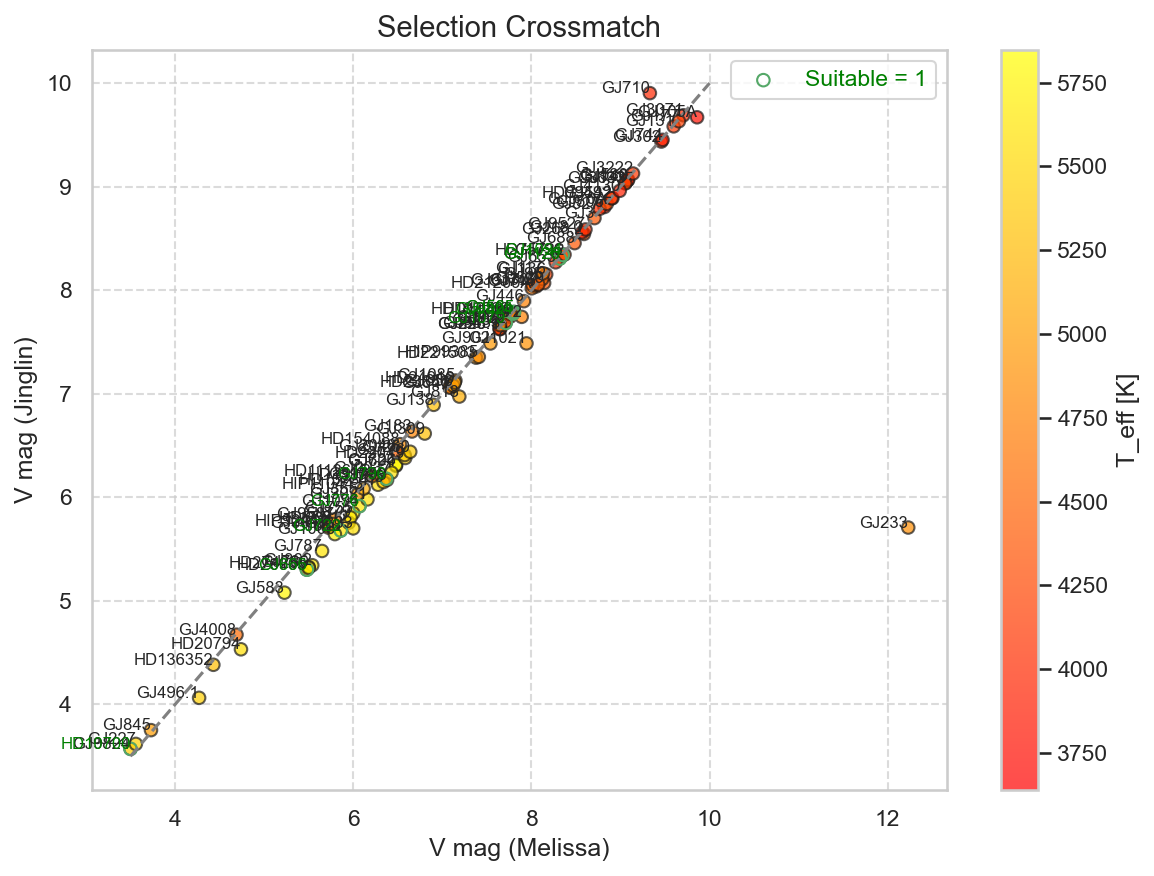

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot with color mapping
plt.figure(figsize=(8, 6), dpi=150)
scatter = plt.scatter(
    merged_result['Vmag'], 
    merged_result['V_mag'], 
    c=merged_result['T_eff [K]'], 
    cmap='autumn', 
    edgecolor='k', 
    alpha=0.7
)

# Add labels to each point
for i, name in enumerate(merged_result['other name']):
    plt.text(merged_result['Vmag'][i], merged_result['V_mag'][i], name, fontsize=8, ha='right')

# Add titles and labels
plt.title('Selection Crossmatch', fontsize=14)
plt.xlabel('V mag (Melissa)', fontsize=12)
plt.ylabel('V mag (Jinglin)', fontsize=12)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('T_eff [K]', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Overplot the suitable points from df_Melissa
suitable_indices = df_Melissa['suitable'] == 1
name_suitable = df_Melissa.loc[suitable_indices, 'other name']

x_suitable = []
y_suitable = []

for name in name_suitable:
    x_value = df_Melissa.loc[df_Melissa['other name'] == name, 'Vmag'].values[0]
    if name in merged_result['other name'].values:        
        y_value = merged_result.loc[merged_result['other name'] == name, 'V_mag'].values[0]
    else:
        y_value = 0
    x_suitable.append(x_value)
    y_suitable.append(y_value)

    plt.text(x_value, y_value, name, fontsize=8, ha='right', color='green')

# Plot the suitable points
plt.scatter(x_suitable, y_suitable, edgecolor='g', facecolors='none', label='Suitable = 1')

# Plot the x = y line
min_value = min(min(merged_result['Vmag']), min(merged_result['V_mag']))
max_value = 10
plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', )

# Add legend
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('green')

# Show the plot
plt.tight_layout()
plt.show()


In [91]:
# 6721432232656218752	6721432232656219136	273,0899282	-43,44664533	7,843331814	8,609505653	7,023746014	1,58575964	75,74537047	4235.4004	0.66545904	0.13317624	0.6776436	K				
# 	               6721432232656218752	273,0899538	-43,44670336	7,846924782	8,58617115	7,012911797	1,573259354	75,71222519	4235.4004	0.66545904	0.13317624	0.6776436	K	HD 166348	GJ 707	HIP 89211	HighPM*


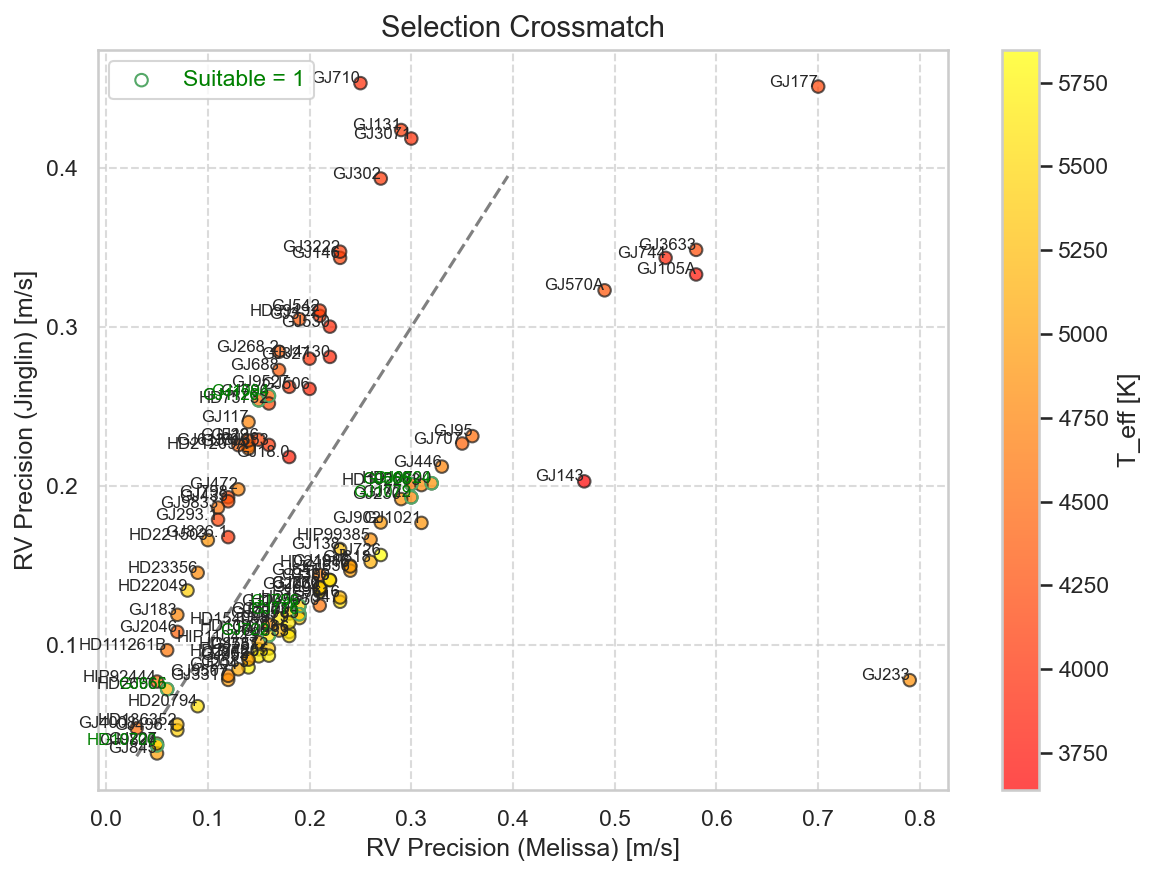

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot with color mapping
plt.figure(figsize=(8, 6), dpi=150)
scatter = plt.scatter(
    merged_result['Reiners RV precision'], 
    merged_result['RV precision [m/s]'], 
    c=merged_result['T_eff [K]'], 
    cmap='autumn', 
    edgecolor='k', 
    alpha=0.7
)

# Add labels to each point
for i, name in enumerate(merged_result['other name']):
    plt.text(merged_result['Reiners RV precision'][i], merged_result['RV precision [m/s]'][i], name, fontsize=8, ha='right')

# Add titles and labels
plt.title('Selection Crossmatch', fontsize=14)
plt.xlabel('RV Precision (Melissa) [m/s]', fontsize=12)
plt.ylabel('RV Precision (Jinglin) [m/s]', fontsize=12)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('T_eff [K]', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Overplot the suitable points from df_Melissa
suitable_indices = df_Melissa['suitable'] == 1
name_suitable = df_Melissa.loc[suitable_indices, 'other name']

x_suitable = []
y_suitable = []

for name in name_suitable:
    x_value = df_Melissa.loc[df_Melissa['other name'] == name, 'Reiners RV precision'].values[0]
    if name in merged_result['other name'].values:        
        y_value = merged_result.loc[merged_result['other name'] == name, 'RV precision [m/s]'].values[0]
    else:
        y_value = 0
    x_suitable.append(x_value)
    y_suitable.append(y_value)

    # name = df_Melissa.loc[df_Melissa['Reiners RV precision'] == x, 'other name'].values[0]
    plt.text(x_value, y_value, name, fontsize=8, ha='right', color='green')

# Plot the suitable points
plt.scatter(x_suitable, y_suitable, edgecolor='g', facecolors='none', label='Suitable = 1')

# Plot the x = y line
min_value = min(min(merged_result['Reiners RV precision']), min(merged_result['RV precision [m/s]']))
max_value = max(max(merged_result['Reiners RV precision'])*0.5, max(merged_result['RV precision [m/s]'])*0.5)
plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', )

# Add legend
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('green')

# Show the plot
plt.tight_layout()
plt.savefig('../figures/RV_precision_comparison.png')
plt.show()


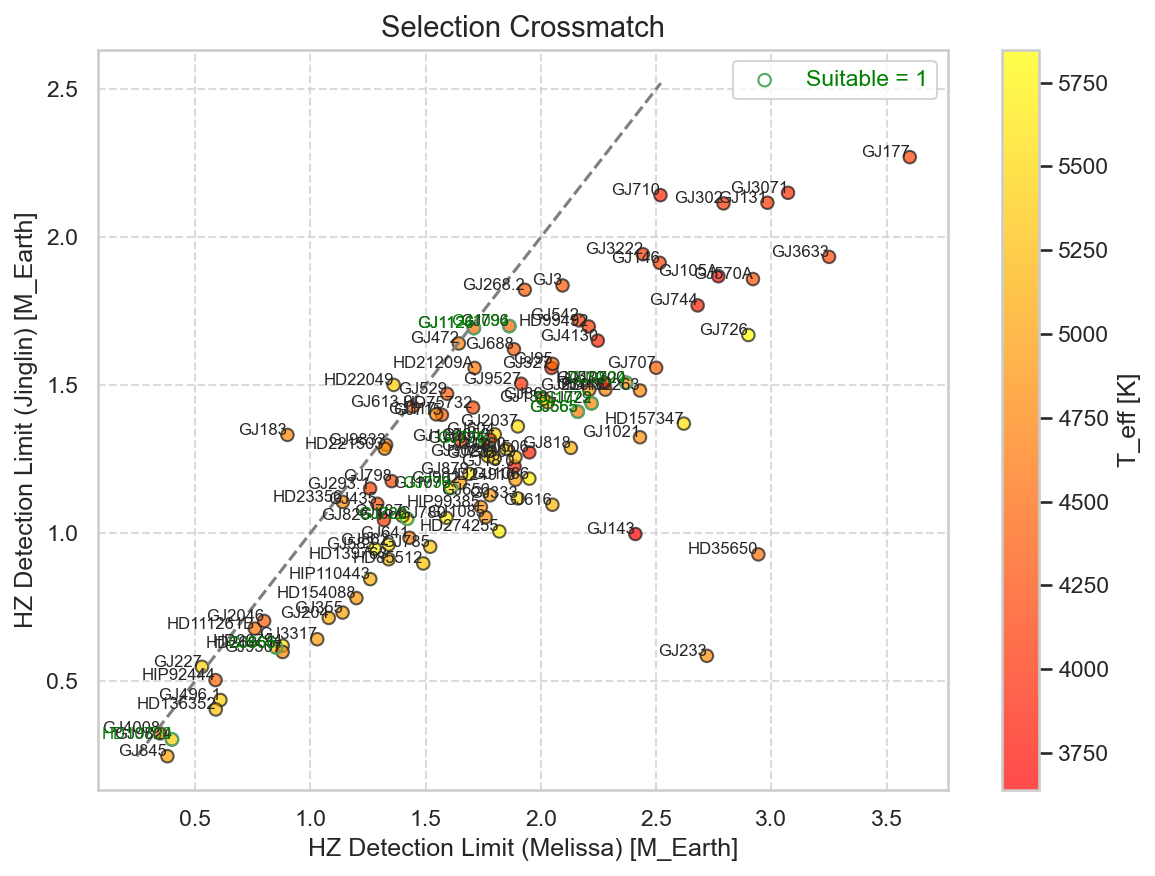

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot with color mapping
plt.figure(figsize=(8, 6), dpi=150)
scatter = plt.scatter(
    merged_result['Reiners HZ Me limit'], 
    merged_result['HZ Detection Limit [Earth Mass]'], 
    c=merged_result['T_eff [K]'], 
    cmap='autumn', 
    edgecolor='k', 
    alpha=0.7
)

# Add labels to each point
for i, name in enumerate(merged_result['other name']):
    plt.text(merged_result['Reiners HZ Me limit'][i], merged_result['HZ Detection Limit [Earth Mass]'][i], name, fontsize=8, ha='right')

# Add titles and labels
plt.title('Selection Crossmatch', fontsize=14)
plt.xlabel('HZ Detection Limit (Melissa) [M_Earth]', fontsize=12)
plt.ylabel('HZ Detection Limit (Jinglin) [M_Earth]', fontsize=12)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('T_eff [K]', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Overplot the suitable points from df_Melissa
suitable_indices = df_Melissa['suitable'] == 1
name_suitable = df_Melissa.loc[suitable_indices, 'other name']

x_suitable = []
y_suitable = []

for name in name_suitable:
    x_value = df_Melissa.loc[df_Melissa['other name'] == name, 'Reiners HZ Me limit'].values[0]
    if name in merged_result['other name'].values:        
        y_value = merged_result.loc[merged_result['other name'] == name, 'HZ Detection Limit [Earth Mass]'].values[0]
    else:
        y_value = 0
    x_suitable.append(x_value)
    y_suitable.append(y_value)

    # Add red labels for suitable points
    plt.text(x_value, y_value, name, fontsize=8, ha='right', color='green')

# Plot the suitable points
plt.scatter(x_suitable, y_suitable, edgecolor='g', facecolors='none', label='Suitable = 1')

# Plot the x = y line
min_value = min(min(merged_result['Reiners HZ Me limit']), min(merged_result['HZ Detection Limit [Earth Mass]']))
max_value = max(max(merged_result['Reiners HZ Me limit'])*0.7, max(merged_result['HZ Detection Limit [Earth Mass]'])*0.7)
plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', )

# Add legend
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('green')

# Show the plot
plt.tight_layout()
plt.savefig('../figures/HZ_detection_limit_comparison.png')
plt.show()



# Others

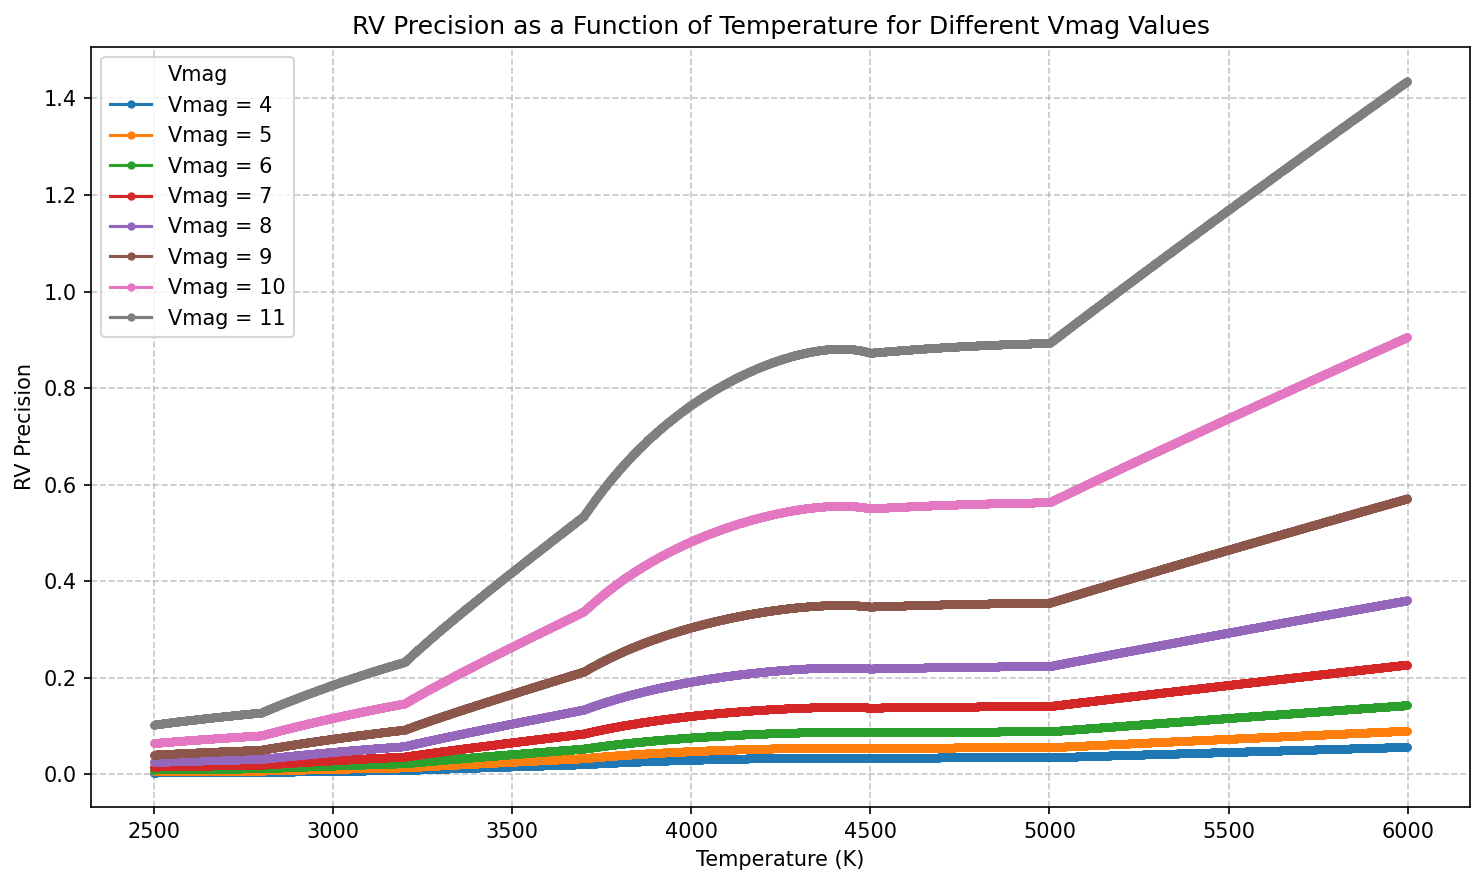

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define temperature and Vmag ranges
temperatures = np.arange(2500, 6000, 1)
vmags = np.arange(4, 12, 1)

# Store RV precision results
rv_precision_results = {vmag: [] for vmag in vmags}

# Calculate RV precision for each combination of temperature and Vmag
for temperature in temperatures:
    for vmag in vmags:
        result, rv_precision = calculate_rv_precision(Temp=temperature, Vmag=vmag)
        rv_precision_results[vmag].append(rv_precision)

# Plotting
plt.figure(figsize=(10, 6), dpi=150)
for vmag, rv_precisions in rv_precision_results.items():
    plt.plot(temperatures, rv_precisions, label=f'Vmag = {vmag}', marker='.')

# Add titles and labels
plt.title('RV Precision as a Function of Temperature for Different Vmag Values')
plt.xlabel('Temperature (K)')
plt.ylabel('RV Precision [m/s]')
plt.legend(title='Vmag')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [231]:
from astroquery.vizier import Vizier
import pandas as pd

# Initialize Vizier with a row limit, you can adjust this as needed
Vizier.ROW_LIMIT = 100  # Set to -1 for no limit

# Define the catalog you want to query
catalog = "V/137D"  # This is an example catalog, you might need to adjust based on your needs

# Define the columns you are interested in
columns = ['Teff', 'Mass', 'Radius', 'Vmag']

# Perform the query
result = Vizier(columns=columns).query_constraints(catalog=catalog)

# Check if any results were returned
if result:
    # Convert the result to a pandas DataFrame
    df = result[0].to_pandas()
    
    # Display the first few rows of the DataFrame
    print(df.head())
else:
    print("No data found for the specified query.")

   Vmag
0  9.10
1  9.27
2  6.61
3  8.06
4  8.55


In [237]:
from astroquery.vizier import Vizier
import pandas as pd

# Initialize Vizier with a row limit
Vizier.ROW_LIMIT = 1  # Since we're looking for a specific star

# Example catalog: Hipparcos catalog
catalog = "I/239/hip_main"  # Hipparcos Main Catalogue

# Define the object name
star_name = "HD 10700"

# Perform the query
result = Vizier.query_object(star_name, catalog=catalog)

# Check if any results were returned
if result:
    # Convert the result to a pandas DataFrame
    df = result[0].to_pandas()
    
    # Print the available columns to see what data we have
    print("Available columns:", df.columns)
    
    # Display the first few rows of the DataFrame
    display(df.head())
else:
    print("No data found for the specified query.")


Available columns: Index(['HIP', 'RAhms', 'DEdms', 'Vmag', 'RAICRS', 'DEICRS', 'Plx', 'pmRA',
       'pmDE', 'e_Plx', 'B-V', 'Notes', '_RA.icrs', '_DE.icrs'],
      dtype='object')


HIP        RAhms        DEdms  Vmag     RAICRS     DEICRS         Plx  \
0  8102  01 44 05.13  -15 56 22.4  3.49  26.021364 -15.939556  274.170013   

      pmRA    pmDE  e_Plx    B-V Notes   _RA.icrs  _DE.icrs  
0 -1721.82  854.07    0.8  0.727        26.017012 -15.93748